# Introduction
Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many water points already established in the country, but some are in need of repair while others have failed altogether.

The aim of this project is to buold a classifier that predicts the condition of a water well (functional, non-function, or functional but needs repair), using information such as the extraction type, how it is managed, payment type, waterpoint type, the water source, whether it has a permit, and whether a public meeting was held.

With this model, the aim is to help the Government of Tanzania find patterns in non-functional wells to influence how new wells are built. 


# Problem Statement

Payments: Wells where no payments are made
Water source: Wells with a shallow well as the water source
Management Group: Wells managed by the user group
Extraction type: Wells with gravity as the extraction type
Permit: Wells that are permitted
Public meeting: Wells where a public meeting was held

# Objectives

# Data Understanding 
The original data can be obtained by the DrivenData 'Pump it Up: Data Mining the Water Table' competition. Basically, there are 4 different data sets; submission format, training set, test set and train labels set which contains status of wells. With given training set and labels set, competitors are expected to build predictive model and apply it to test set to determine status of the wells and submit.

In this project, we will use train set and train label set. Train set has 59400 water points data with 40 features. Train labels data has 59400 same water points with train set but just has information about id of these points and status of them

### Limitations of the data
1. The target labels are highly imbalanced: 
- functional: 32259
- non functional: 22824
- functional needs repair: 4317<br>

  This might impact the performance of the model

2. The data contains 41 variables, which means that a lot of work will go into EDA and feature elimination

# Imports and Data Loading

#### Imports

In [1330]:


import warnings

# Figures
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics

# Data
import pandas as pd
import numpy as np
from operator import itemgetter
import itertools
from collections import defaultdict
from datetime import datetime

# Models, metrics, scalers and functionalities
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_selection import SelectFromModel

from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
 
from IPython.display import Image
from sklearn.tree import export_graphviz

from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

import xgboost
import pandas as pd
import numpy as np


#### Data Loading

In [1331]:
training_set_values = pd.read_csv("data/training-set-values.csv")
training_set_labels = pd.read_csv("data/training-set-labels.csv")
print(training_set_values.shape)
print(training_set_labels.shape)

(59400, 40)
(59400, 2)


Both the training labels and values csvs have 59,400 rows. We will now combine them to deal with one training dataset

In [1332]:
training_data = training_set_values.merge(training_set_labels, on='id')
training_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# EDA and Feature Exploration

In [1333]:
training_data.shape

(59400, 41)

We now have one dataframe with 59,400 rows and 41 columns, with the 41st column being the status_group column

In [1334]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [1335]:
training_data.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

These are all the columns and their descriptions:
- **amount_tsh** - Total static head (amount water available to waterpoint)
- **date_recorded** - The date the row was entered
- **funder** - Who funded the well
- **gps_height** - Altitude of the well
- **installer** - Organization that installed the well
- **longitude** - GPS coordinate
- **latitude** - GPS coordinate
- **wpt_name** - Name of the waterpoint if there is one
- **num_private** -
- **basin** - Geographic water basin
- **subvillage** - Geographic location
- **region** - Geographic location
- **region_code** - Geographic location (coded)
- **district_code** - Geographic location (coded)
- **lga** - Geographic location
- **ward** - Geographic location
- **population** - Population around the well
- **public_meeting** - True/False
- **recorded_by** - Group entering this row of data
- **scheme_management** - Who operates the waterpoint
- **scheme_name** - Who operates the waterpoint
- **permit** - If the waterpoint is permitted
- **construction_year** - Year the waterpoint was constructed
- **extraction_type** - The kind of extraction the waterpoint uses
- **extraction_type_group** - The kind of extraction the waterpoint uses
- **extraction_type_class** - The kind of extraction the waterpoint uses
- **management** - How the waterpoint is managed
- **management_group** - How the waterpoint is managed
- **payment** - What the water costs
- **payment_type** - What the water costs
- **water_quality** - The quality of the water
- **quality_group** - The quality of the water
- **quantity** - The quantity of water
- **quantity_group** - The quantity of water
- **source** - The source of the water
- **source_type** - The source of the water
- **source_class** - The source of the water
- **waterpoint_type** - The kind of waterpoint
- **waterpoint_type_group** - The kind of waterpoint
- **status_group** - The labels in this dataset with three possible values: functional, non-functional, and functional needs repair

In [1336]:
training_data.isna().sum() # to see the null values

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

The columns with missing values are:<br>
Funder : 3635  
Installer: 3635  
Subvillage: 371  
Public meeting: 3334  
scheme_management:3877  
scheme_name: 28166  
permit: 3056

There are some columns which contain null and the same information in the data set. 

Now, we will drop one for each because the same values or dublicated values do not affect our target, and when we simplify our data we can run our models easier. These are `management and scheme_management`, `payment and payment type`, `quantity and quantity group`, `waterpoint_type and waterpoint_type_group`, `extraction_type, extration_type_class, and extraction_type_group`, `source, source_type, and source_class`, `water_quality and quality_group`  Let's assess them to confirm.

## Dealing with columns that have the same information

##### Management and Scheme_management

In [1337]:
print(training_data.management.value_counts())
print("---------------------------------")
print(training_data.scheme_management.value_counts())

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64
---------------------------------
VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64


These two columns has nearly same information. Scheme_management represents who operates the water point, 'management' represents how the water point is managed. There are 3877 null values in 'scheme_management' column so we prefer to keep the 'management' column. 

In [1338]:
training_data.drop('scheme_management', axis=1, inplace=True)

##### Payment and Payment type

In [1339]:
# Looking at payment and payment_type
print(training_data.payment.value_counts())
print("---------------------------------")
print(training_data.payment_type.value_counts())

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64
---------------------------------
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64


These two columns have the same exact information, but `payment` has more details on the column naming, so we will keep it and drop`payment_type`

In [1340]:
training_data.drop('payment_type', axis=1, inplace=True)

##### Quantity and Quantity_Group

In [1341]:
# Looking at `quantity and quantity group`
print(training_data.quantity.value_counts())
print("---------------------------------")
print(training_data.quantity_group.value_counts())

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64
---------------------------------
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64


These have the same exact information, so we can drop either

In [1342]:
training_data.drop('quantity_group', axis=1, inplace=True)

##### Waterpoint Type and Waterpoint_type_group

In [1343]:
# Looking at the waterpoint_type and waterpoint_type_group columns
print(training_data.waterpoint_type.value_counts())
print("---------------------------------")
print(training_data.waterpoint_type_group.value_counts())

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64
---------------------------------
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64


`Waterpoint_type` has more information and distribution, so we will keep it and drop `waterpoint_type_group`

In [1344]:
training_data.drop(columns = 'waterpoint_type_group', axis=1, inplace=True)

##### Extraction_type, Extraction_type_class and Extraction_type_group columns

In [1345]:
# Let's look at the extraction_type, extraction_type_class and extraction_type_group columns
print(training_data.extraction_type.value_counts())

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64


In [1346]:
print(training_data.extraction_type_group.value_counts())

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64


In [1347]:
print(training_data.extraction_type_class.value_counts())

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64


`extraction_type_class` is an even further simplification of `extraction_type`. Since it is the simplest feature of the three, this is the one selected for use, and the handling of category level other will take place after dummification.

In [1348]:
training_data.drop('extraction_type_group', axis=1, inplace=True)

In [1349]:
training_data.drop('extraction_type', axis=1, inplace=True)

##### Source, Source_type_and Source_class

In [1350]:
# Let's assess the source, source_type_and source_class columns
# SOURCE
print(training_data.source.value_counts())

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64


In [1351]:
# SOURCE TYPE
print(training_data.source_type.value_counts())

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64


In [1352]:
# SOURCE CLASS
print(training_data.source_class.value_counts())

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64


It is obvious that these columns have the same information. We will keep the `source` column and drop the rest since it has more information

In [1353]:
training_data.drop('source_type', axis=1, inplace=True)

In [1354]:
training_data.drop('source_class', axis=1, inplace=True)

##### Water_quality and Quality_group

In [1355]:
# Looking at the water_quality and quality_group columns
print(training_data.water_quality.value_counts())
print("---------------------------------")
print(training_data.quality_group.value_counts())

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64
---------------------------------
good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64


Since `quality_group` has less categories, we will keep it and drop `water_quality`

In [1356]:
training_data.drop('water_quality', axis=1, inplace=True)

In [1357]:
# Let's look at our new data
training_data.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_name',
       'permit', 'construction_year', 'extraction_type_class', 'management',
       'management_group', 'payment', 'quality_group', 'quantity', 'source',
       'waterpoint_type', 'status_group'],
      dtype='object')

In [1358]:
training_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,construction_year,extraction_type_class,management,management_group,payment,quality_group,quantity,source,waterpoint_type,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,1999,gravity,vwc,user-group,pay annually,good,enough,spring,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,2010,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,2009,gravity,vwc,user-group,pay per bucket,good,enough,dam,communal standpipe multiple,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,1986,submersible,vwc,user-group,never pay,good,dry,machine dbh,communal standpipe multiple,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,0,gravity,other,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,functional


##### Conclusion from dealing with columns that have similar data

We dropped the following columns in favor of those with more robust data:
- `scheme_management`, `payment_type`, `quantity_group`, `waterpoint_type_group`, `extraction_type`, `extration_type_group`, `source_type`, `source_class`, `water_quality`  

The kept columns are:
- `management`, `payment`, `quantity`, `waterpoint`, `extraction_type_class`, `source`, `quality_group`

## Dealing with Null Values

In [1359]:
training_data.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_name              28166
permit                    3056
construction_year            0
extraction_type_class        0
management                   0
management_group             0
payment                      0
quality_group                0
quantity                     0
source                       0
waterpoint_type              0
status_group                 0
dtype: i

Let's deal with the columns containing missing values, starting with Funder

##### Funder

In [1360]:
training_data.funder.value_counts()

Government Of Tanzania       9084
Danida                       3114
Hesawa                       2202
Rwssp                        1374
World Bank                   1349
                             ... 
Germany Missionary              1
Padri                           1
Wahidi                          1
Education Funds                 1
Dar Es Salaam Round Table       1
Name: funder, Length: 1897, dtype: int64

In [1361]:
training_data.funder.value_counts()

Government Of Tanzania       9084
Danida                       3114
Hesawa                       2202
Rwssp                        1374
World Bank                   1349
                             ... 
Germany Missionary              1
Padri                           1
Wahidi                          1
Education Funds                 1
Dar Es Salaam Round Table       1
Name: funder, Length: 1897, dtype: int64

The `funder` column has 1897 unique values, hence it will be difficult to fill the null ones. We will drop it

In [1362]:
training_data.drop('funder', axis=1, inplace=True)

##### Subvillage

In [1363]:
training_data["subvillage"].value_counts()

Madukani      508
Shuleni       506
Majengo       502
Kati          373
Mtakuja       262
             ... 
Sasi A          1
Nyamigumo       1
Butainamwa      1
Mandunda B      1
Kwekidevu       1
Name: subvillage, Length: 19287, dtype: int64

In [1364]:
len(training_data[training_data["subvillage"].isnull()]["subvillage"])/len(training_data)*100

0.6245791245791246

Given the great scatter (not one subvillage accounts for 1% or more of the examples) this feature is not informative, and therefore dropped.

In [1365]:
training_data.drop('subvillage', axis=1, inplace=True)

##### Public Meeting

In [1366]:
training_data["public_meeting"].value_counts(dropna = False)/len(training_data)*100

True     85.877104
False     8.510101
NaN       5.612795
Name: public_meeting, dtype: float64

As it is hard to assume whether or not public meetings were actually held, we consider binning this variable into:

True  
False  
Unknown  

In [1367]:
training_data["public_meeting"] = training_data["public_meeting"].astype("category")
training_data["public_meeting"] = training_data["public_meeting"].cat.add_categories('Unknown').fillna('Unknown')

In [1368]:
training_data.public_meeting.value_counts()

True       51011
False       5055
Unknown     3334
Name: public_meeting, dtype: int64

##### Scheme Name

In [1369]:
training_data["scheme_name"].value_counts(dropna = False)/len(training_data)*100

NaN                            47.417508
K                               1.148148
None                            1.084175
Borehole                        0.919192
Chalinze wate                   0.681818
                                 ...    
Kisale Kitale B water suply     0.001684
Shirimatunda                    0.001684
Zimba water supply              0.001684
nyaluhande                      0.001684
Kibena                          0.001684
Name: scheme_name, Length: 2697, dtype: float64

`scheme_name` has about half the entries as NaN, and the rest are greatly scattered. Feature `scheme_name` is consequently dropped as well.

In [1370]:
training_data.drop('scheme_name', axis=1, inplace=True)

##### Permit

In [1371]:
training_data["permit"].value_counts(dropna = False)/len(training_data)*100

True     65.407407
False    29.447811
NaN       5.144781
Name: permit, dtype: float64

`permit` is an intuitive binary feature. About 5% of the values are missing (NaN). It is reasonable to assume that absence of a permit record implies the absence of the permit itself, and hence the NaN values could be imputed as False

In [1372]:
training_data = training_data.replace({"permit": {np.nan: False}})

In [1373]:
training_data.permit.value_counts()

True     38852
False    20548
Name: permit, dtype: int64

##### Conclusion from dealing with null values

We dropped the following columns:
- `funder`, `subvillage`, and `scheme_name`  

The following columns were kept
- `public_meeting`- NaN values were imputed with 'Unknown', introducing a new category
- `permit`- NaN values were imputed with False

## Checking for duplicates

In [1374]:
training_data.duplicated().sum()

0

There are no duplicates

## Exploring the columns inferred as numeric

In [1375]:
# Find numeric variables
numerical_columns = [var for var in training_data.columns if training_data[var].dtype!='object']

print('There are {} numerical variables\n'.format(len(numerical_columns)))

print('The numerical variables are :', numerical_columns)

There are 12 numerical variables

The numerical variables are : ['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'public_meeting', 'permit', 'construction_year']


In [1376]:
training_data[numerical_columns].head(3)

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,public_meeting,permit,construction_year
0,69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,True,False,1999
1,8776,0.0,1399,34.698766,-2.147466,0,20,2,280,Unknown,True,2010
2,34310,25.0,686,37.460664,-3.821329,0,21,4,250,True,True,2009


Check for null values in numerical columns

In [1377]:
training_data[numerical_columns].isnull().sum()

id                   0
amount_tsh           0
gps_height           0
longitude            0
latitude             0
num_private          0
region_code          0
district_code        0
population           0
public_meeting       0
permit               0
construction_year    0
dtype: int64

None of the numeric columns have missing data

In [1378]:
training_data[numerical_columns].describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


##### Amount tsh

Total static head shows us the height of the flow from the surface. Mostly there are zero values in our dataset. But for zero values no need for pump , because it means we are already in surface.

In [1379]:
training_data["amount_tsh"].value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

In [1380]:
training_data["amount_tsh"].value_counts()/len(training_data)*100

0.0         70.099327
500.0        5.222222
50.0         4.161616
1000.0       2.505051
20.0         2.462963
              ...    
8500.0       0.001684
6300.0       0.001684
220.0        0.001684
138000.0     0.001684
12.0         0.001684
Name: amount_tsh, Length: 98, dtype: float64

We decided to drop this column because 70% of the column has no informative values. So, this column will not be informative to our model and we will drop it.

In [1381]:
training_data.drop('amount_tsh',axis=1, inplace=True)

##### GPS Height

In [1382]:
training_data["gps_height"].value_counts()/len(training_data)*100    # 34% of waterpoints are at height 0, the rest are very scattered

 0       34.407407
-15       0.101010
-16       0.092593
-13       0.092593
-20       0.087542
           ...    
 2285     0.001684
 2424     0.001684
 2552     0.001684
 2413     0.001684
 2385     0.001684
Name: gps_height, Length: 2428, dtype: float64

In [1383]:
training_data[training_data["gps_height"] > 0]["gps_height"].count()/len(training_data)*100  # 63% of waterpoints above sea level
training_data[training_data["gps_height"] < 0]["gps_height"].count()/len(training_data)*100  # 2.5% of waterpoints below sea level

2.5185185185185186

Gps height shows the level of the water point from sea level. There are 34% zero values but maybe 34% of the water points are at the sea level so we do not change this column now.

Let's use the median

##### Longitude and Latitude

**latitude** values make sense (between just below the equator down to 12°S)

**longitude** values have inconsistencies (0°E is not possible for Tanzania)

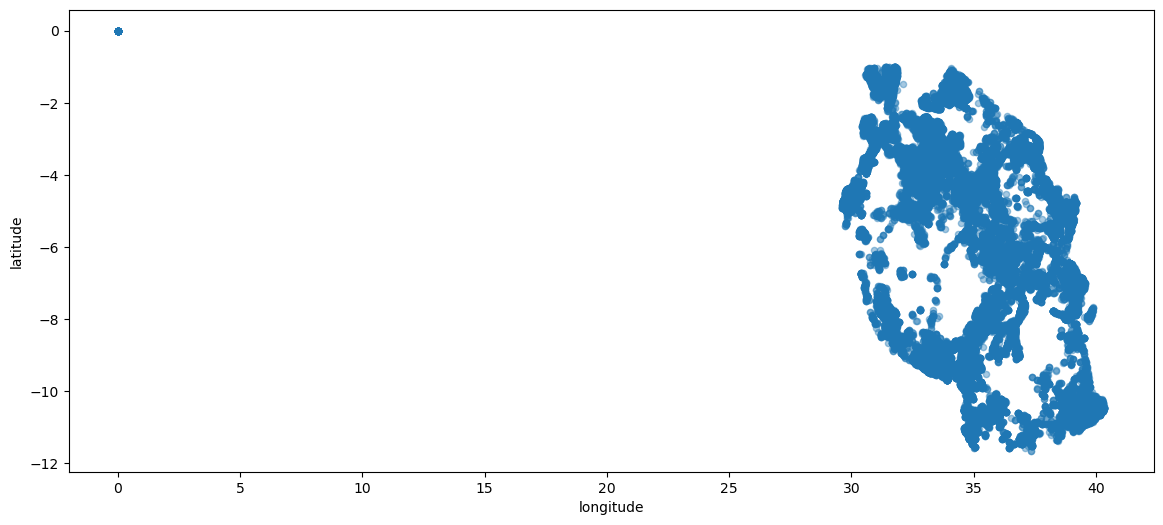

In [1384]:
training_data.plot(kind='scatter', x="longitude", y="latitude", alpha=0.4, figsize=(14,6),sharex=False);
# To see the outliers

In [1385]:
training_data.loc[training_data['longitude']==0].head() # to check outside of Tanzania

,id,date_recorded,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,region,...,construction_year,extraction_type_class,management,management_group,payment,quality_group,quantity,source,waterpoint_type,status_group
21,6091,2013-02-10,0,DWE,0.0,-2.000000e-08,Muungano,0,Lake Victoria,Shinyanga,...,0,handpump,wug,user-group,unknown,unknown,unknown,shallow well,hand pump,functional
53,32376,2011-08-01,0,Government,0.0,-2.000000e-08,Polisi,0,Lake Victoria,Mwanza,...,0,submersible,vwc,user-group,unknown,unknown,dry,machine dbh,communal standpipe multiple,non functional
168,72678,2013-01-30,0,WVT,0.0,-2.000000e-08,Wvt Tanzania,0,Lake Victoria,Shinyanga,...,0,gravity,parastatal,parastatal,other,good,seasonal,rainwater harvesting,communal standpipe,functional
177,56725,2013-01-17,0,DWE,0.0,-2.000000e-08,Kikundi Cha Wakina Mama,0,Lake Victoria,Shinyanga,...,0,other,wug,user-group,unknown,good,enough,shallow well,other,non functional
253,13042,2012-10-29,0,DWE,0.0,-2.000000e-08,Kwakisusi,0,Lake Victoria,Mwanza,...,0,handpump,vwc,user-group,never pay,good,insufficient,shallow well,hand pump,functional needs repair


In [1386]:
training_data.loc[training_data['longitude']!=0].describe() # to find the non-zero values mean

,id,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,57588.00000,57588.000000,57588.000000,57588.000000,57588.000000,57588.000000,57588.000000,57588.000000,57588.000000
mean,37106.48807,689.325137,35.149669,-5.885572,0.489060,15.217615,5.728311,185.570831,1341.577360
std,21454.51421,693.564188,2.607428,2.809876,12.426954,17.855254,9.760254,477.744239,937.641368
min,0.00000,-90.000000,29.607122,-11.649440,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18522.75000,0.000000,33.285100,-8.643841,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37054.50000,426.000000,35.005943,-5.172704,0.000000,12.000000,3.000000,35.000000,1988.000000
75%,55667.25000,1332.000000,37.233712,-3.372824,0.000000,17.000000,5.000000,230.000000,2004.000000
max,74247.00000,2770.000000,40.345193,-0.998464,1776.000000,99.000000,80.000000,30500.000000,2013.000000


It is obviously seen that it is written as 0 when the longtitude is unknown.   
Because, the zero points can seen easily in the graph above outliers and outside of Tanzania.  
So, we replaced this with the mean longitude value

In [1387]:
training_data['longitude'].replace(to_replace = 0 , value =35.15, inplace=True) # changing 0 values to mean

##### Num Private

num_private column has no description and most of the colum contains zeros and is not intuitive to infer. We will drop it

In [1388]:
training_data["num_private"].value_counts()/len(training_data)*100

0      98.725589
6       0.136364
1       0.122896
5       0.077441
8       0.077441
         ...    
180     0.001684
213     0.001684
23      0.001684
55      0.001684
94      0.001684
Name: num_private, Length: 65, dtype: float64

In [1389]:
training_data.drop('num_private',axis=1, inplace=True )

##### Region_code
 

In [1390]:
training_data["region_code"].nunique() 

27

In [1391]:
training_data['region_code'].value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

This is a categorical value

##### District_code

In [1392]:
training_data['district_code'].nunique()

20

In [1393]:
training_data['district_code'].value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

This is a categorical value

##### Population 


In the `population` column, 36% of rows have value 0. These could be mistakes or numeric encoding for NA (maybe waterpoints where population ultimately migrated?).

Do we impute these entries? The distribution is considerably skewed.

In [1394]:
print(training_data['population'].skew())

12.660713588843592


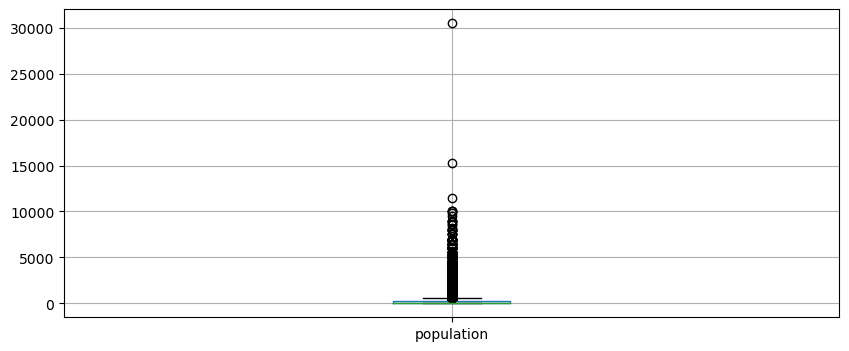

In [1395]:
plt.figure(figsize=(10,4))
training_data.boxplot(['population'], grid=True, fontsize=10)
plt.show()

In [1396]:
training_data["population"].describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

imputation is prefered to be with the median considering the significant skewness.

In [1397]:
population_median = training_data[(training_data["population"] != 0)]["population"].describe()[5]

In [1398]:
training_data["population"] = training_data["population"].replace({0:population_median}).astype('int64')

In [1399]:
training_data.population.value_counts()

150     23273
1        7025
200      1940
250      1681
300      1476
        ...  
406         1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1048, dtype: int64

##### Permit

In [1400]:
training_data['permit']

0        False
1         True
2         True
3         True
4         True
         ...  
59395     True
59396     True
59397    False
59398     True
59399     True
Name: permit, Length: 59400, dtype: bool

In [1401]:
training_data["permit"].value_counts(dropna = False)/len(training_data)*100

True     65.407407
False    34.592593
Name: permit, dtype: float64

`Permit` is an intuitive binary feature with Boolean values (True or False)

##### Construction_year   

In [1402]:
print(training_data['construction_year'].skew())

-0.6349277865999228


In [1403]:
training_data["construction_year"].value_counts()/len(training_data)*100

0       34.863636
2010     4.452862
2008     4.398990
2009     4.264310
2000     3.520202
2007     2.671717
2006     2.476431
2003     2.164983
2011     2.114478
2004     1.890572
2012     1.824916
2002     1.809764
1978     1.745791
1995     1.707071
2005     1.702020
1999     1.648148
1998     1.626263
1990     1.606061
1985     1.590909
1980     1.365320
1996     1.365320
1984     1.311448
1982     1.252525
1994     1.242424
1972     1.191919
1974     1.138047
1997     1.084175
1992     1.077441
1993     1.023569
2001     0.909091
1988     0.877104
1983     0.821549
1975     0.735690
1986     0.730640
1976     0.696970
1970     0.691919
1991     0.545455
1989     0.531987
1987     0.508418
1981     0.400673
1977     0.340067
1979     0.323232
1973     0.309764
2013     0.296296
1971     0.244108
1960     0.171717
1967     0.148148
1963     0.143098
1968     0.129630
1969     0.099327
1964     0.067340
1962     0.050505
1961     0.035354
1965     0.031987
1966     0.028620
Name: cons

In [1404]:
training_data[(training_data["construction_year"] != 0)]['construction_year'].describe()

count    38691.000000
mean      1996.814686
std         12.472045
min       1960.000000
25%       1987.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64

Imputation is preferred to be with the mean of non-zero years, as it is considered that a majority a missing values stem from older decades.

In [1405]:
construction_year_mean = training_data[(training_data["construction_year"] != 0)]["construction_year"].describe()[1]

In [1406]:
training_data["construction_year"] = training_data["construction_year"].replace({0:construction_year_mean}).astype('int64')

In [1407]:
training_data["construction_year"].value_counts()/len(training_data)*100

1996    36.228956
2010     4.452862
2008     4.398990
2009     4.264310
2000     3.520202
2007     2.671717
2006     2.476431
2003     2.164983
2011     2.114478
2004     1.890572
2012     1.824916
2002     1.809764
1978     1.745791
1995     1.707071
2005     1.702020
1999     1.648148
1998     1.626263
1990     1.606061
1985     1.590909
1980     1.365320
1984     1.311448
1982     1.252525
1994     1.242424
1972     1.191919
1974     1.138047
1997     1.084175
1992     1.077441
1993     1.023569
2001     0.909091
1988     0.877104
1983     0.821549
1975     0.735690
1986     0.730640
1976     0.696970
1970     0.691919
1991     0.545455
1989     0.531987
1987     0.508418
1981     0.400673
1977     0.340067
1979     0.323232
1973     0.309764
2013     0.296296
1971     0.244108
1960     0.171717
1967     0.148148
1963     0.143098
1968     0.129630
1969     0.099327
1964     0.067340
1962     0.050505
1961     0.035354
1965     0.031987
1966     0.028620
Name: construction_year, dty

##### Conclusion from exploring numeric values
- `Amount_tsh` was dropped
- `GPS Height` remains as it is
- `Longitude` remains as is
- For `latitude`, we imputed the 0 values with the mean since it does not make sense to have a latitude of 0 in Tanzania
- `Num private` was dropped
- `Region code and district code` are categorical values and remain as they are 
- `Population` needs to be imputed with the median for the years listed as zero
- `Permit` is an intuitive binary feature with Boolean values (True or False)
- `Construction year` will be imputed with the mean of non-zero years for the years listed as zero

Let's look at our new data

In [1408]:
training_data.columns

Index(['id', 'date_recorded', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'basin', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'recorded_by', 'permit', 'construction_year', 'extraction_type_class',
       'management', 'management_group', 'payment', 'quality_group',
       'quantity', 'source', 'waterpoint_type', 'status_group'],
      dtype='object')

## Explore the columns inferred as non-numeric
Initially all these columns are inferred as type object

In [1409]:
categorical_columns = [col for col in training_data.columns if training_data[col].dtypes == 'O']

categorical_columns

['date_recorded',
 'installer',
 'wpt_name',
 'basin',
 'region',
 'lga',
 'ward',
 'recorded_by',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'quality_group',
 'quantity',
 'source',
 'waterpoint_type',
 'status_group']

In [1410]:
training_data[categorical_columns].isnull().sum()

date_recorded               0
installer                3655
wpt_name                    0
basin                       0
region                      0
lga                         0
ward                        0
recorded_by                 0
extraction_type_class       0
management                  0
management_group            0
payment                     0
quality_group               0
quantity                    0
source                      0
waterpoint_type             0
status_group                0
dtype: int64

##### Date_recorded

We can see that the data type of `Date` variable is object. I will parse the date currently coded as object into datetime format.

In [1411]:
training_data["date_recorded"] = pd.to_datetime(training_data["date_recorded"])

In [1412]:
# extract year from date

training_data['year_recorded'] = training_data['date_recorded'].dt.year
training_data['year_recorded'].head()

0    2011
1    2013
2    2013
3    2013
4    2011
Name: year_recorded, dtype: int64

In [1413]:
training_data['month_recorded'] = training_data['date_recorded'].dt.month

training_data['month_recorded'].head()

0    3
1    3
2    2
3    1
4    7
Name: month_recorded, dtype: int64

In [1414]:
# extract day from date

training_data['day_recorded'] = training_data['date_recorded'].dt.day

training_data['day_recorded'].head()

0    14
1     6
2    25
3    28
4    13
Name: day_recorded, dtype: int64

In [1415]:
# again view the summary of dataset

training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     59400 non-null  int64         
 1   date_recorded          59400 non-null  datetime64[ns]
 2   gps_height             59400 non-null  int64         
 3   installer              55745 non-null  object        
 4   longitude              59400 non-null  float64       
 5   latitude               59400 non-null  float64       
 6   wpt_name               59400 non-null  object        
 7   basin                  59400 non-null  object        
 8   region                 59400 non-null  object        
 9   region_code            59400 non-null  int64         
 10  district_code          59400 non-null  int64         
 11  lga                    59400 non-null  object        
 12  ward                   59400 non-null  object        
 13  p

We can see that there are three additional columns created from `date_recorded` variable. Now, I will drop the original `date_recorded` variable from the dataset.

In [1416]:
training_data.drop('date_recorded', axis=1, inplace = True)

In [1417]:
training_data.head()

,id,gps_height,installer,longitude,latitude,wpt_name,basin,region,region_code,district_code,...,management_group,payment,quality_group,quantity,source,waterpoint_type,status_group,year_recorded,month_recorded,day_recorded
0,69572,1390,Roman,34.938093,-9.856322,none,Lake Nyasa,Iringa,11,5,...,user-group,pay annually,good,enough,spring,communal standpipe,functional,2011,3,14
1,8776,1399,GRUMETI,34.698766,-2.147466,Zahanati,Lake Victoria,Mara,20,2,...,user-group,never pay,good,insufficient,rainwater harvesting,communal standpipe,functional,2013,3,6
2,34310,686,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Manyara,21,4,...,user-group,pay per bucket,good,enough,dam,communal standpipe multiple,functional,2013,2,25
3,67743,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mtwara,90,63,...,user-group,never pay,good,dry,machine dbh,communal standpipe multiple,non functional,2013,1,28
4,19728,0,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,Kagera,18,1,...,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,functional,2011,7,13


##### Installer

In [1418]:
training_data["installer"].value_counts(dropna = False)/len(training_data)*100

DWE                29.296296
NaN                 6.153199
Government          3.072391
RWE                 2.030303
Commu               1.784512
                     ...    
KOYI                0.001684
Great Lakes         0.001684
Wafidh              0.001684
TCRS TWESA          0.001684
Mwamvita Rajabu     0.001684
Name: installer, Length: 2146, dtype: float64

Given the scatter of installers with only one entry, and that with 2146 different funders it seems complicated to find a common cluster parameter for the specific feature, it is decided to drop installer.

##### wpt_name

In [1419]:
training_data["wpt_name"].value_counts()/len(training_data)*100

none                     5.998316
Shuleni                  2.942761
Zahanati                 1.397306
Msikitini                0.900673
Kanisani                 0.543771
                           ...   
Kwa Mzee Ally Kimesha    0.001684
Ifutauchafu              0.001684
Kwa Boha                 0.001684
Area 17 Namba 33         0.001684
Kwa Alli Mbaga           0.001684
Name: wpt_name, Length: 37400, dtype: float64

`wpt_name` should play the role of a label but it has null values ("none") and it is not unique (also, the numeric column id is already a valid index). Hence, `wpt_name` is dropped.

In [1420]:
training_data.drop('wpt_name', axis=1, inplace = True)

##### Basin

In [1421]:
training_data["basin"].value_counts()/len(training_data)*100

Lake Victoria              17.252525
Pangani                    15.050505
Rufiji                     13.427609
Internal                   13.106061
Lake Tanganyika            10.828283
Wami / Ruvu                10.079125
Lake Nyasa                  8.560606
Ruvuma / Southern Coast     7.563973
Lake Rukwa                  4.131313
Name: basin, dtype: float64

basin is a nice clustering feature (hydrographic clustering) and has no null values.

##### Region

In [1422]:
training_data["region"].value_counts()/len(training_data)*100

Iringa           8.912458
Shinyanga        8.387205
Mbeya            7.809764
Kilimanjaro      7.372054
Morogoro         6.744108
Arusha           5.639731
Kagera           5.582492
Mwanza           5.222222
Kigoma           4.740741
Ruvuma           4.444444
Pwani            4.436027
Tanga            4.287879
Dodoma           3.705387
Singida          3.523569
Mara             3.314815
Tabora           3.297980
Rukwa            3.043771
Mtwara           2.912458
Manyara          2.664983
Lindi            2.602694
Dar es Salaam    1.355219
Name: region, dtype: float64

There are 21 distinct values, whereas region_code had 27. Either of them could work as geographic clustering feature.

##### Lga

In [1423]:
training_data["lga"].value_counts()/len(training_data)*100

Njombe          4.213805
Arusha Rural    2.107744
Moshi Rural     2.106061
Bariadi         1.981481
Rungwe          1.861953
                  ...   
Moshi Urban     0.132997
Kigoma Urban    0.119529
Arusha Urban    0.106061
Lindi Urban     0.035354
Nyamagana       0.001684
Name: lga, Length: 125, dtype: float64

`lga` could be an administrative/political clustering feature, but it has too many levels and classification is not intuitive. Therefore, this feature is dropped.

In [1424]:
training_data.drop('lga', axis=1, inplace=True)

##### Ward

In [1425]:
training_data["ward"].value_counts()/len(training_data)*100

Igosi        0.516835
Imalinyi     0.424242
Siha Kati    0.390572
Mdandu       0.388889
Nduruma      0.365320
               ...   
Matarawe     0.001684
Kirongo      0.001684
Rasbura      0.001684
Uchindile    0.001684
Korongoni    0.001684
Name: ward, Length: 2092, dtype: float64

`ward` seems too scattered to be informative (not one value accounts for even 0.6%) and is therefore dropped.

In [1426]:
training_data.drop('ward', axis=1, inplace=True)

In [1427]:
training_data['public_meeting'].value_counts()

True       51011
False       5055
Unknown     3334
Name: public_meeting, dtype: int64

##### Recorded by

In [1428]:
training_data["recorded_by"].value_counts()/len(training_data)*100

GeoData Consultants Ltd    100.0
Name: recorded_by, dtype: float64

`recorded_by` comprises only one value, constant across the whole dataset. This feature is uninformative and must be dropped.

In [1429]:
training_data.drop('recorded_by', axis=1, inplace=True)

##### Scheme name
Scheme name was dropped when dealing with null values

##### Extraction type class
This was handled when eliminating redundant categories

##### Management
This was handled when dealing with redundant categories

In [1430]:
training_data['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

##### Management Group

In [1431]:
training_data['management_group'].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

management_group is chosen over management. It has nulls (0.91%) as unknown that are handled after dummification.  
We will drop the management column

In [1432]:
training_data.drop('management', axis=1, inplace=True)

##### Payment
This was dealt with when dealing with redundant columns

##### Quality Group
This was dealt with when dealing with redundant columns

##### Quantity 

In [1433]:
training_data["quantity"].value_counts()/len(training_data)*100

enough          55.868687
insufficient    25.469697
dry             10.515152
seasonal         6.818182
unknown          1.328283
Name: quantity, dtype: float64

##### Source

This was dealt with when dealing with redundant columns

##### Waterpoint Type
This was dealt with when dealing with redundant columns

##### Conclusion from dealing with non-numeric columns

The following columns were dropped:  
- `wpt_name`, `installer`, `recorded_by`, `scheme_name`

The following columns were kept:
- `date_recorded` was converted into datetime format
- `basin` was kept
- `region`
- `lga`
- `ward`
- `extraction_type_class`
- `management_group`
- `payment`
- `quality_group`
- `source`
- `waterpoint_type`

Let's look at our new dataset

In [1434]:
training_data.head()

,id,gps_height,installer,longitude,latitude,basin,region,region_code,district_code,population,...,management_group,payment,quality_group,quantity,source,waterpoint_type,status_group,year_recorded,month_recorded,day_recorded
0,69572,1390,Roman,34.938093,-9.856322,Lake Nyasa,Iringa,11,5,109,...,user-group,pay annually,good,enough,spring,communal standpipe,functional,2011,3,14
1,8776,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,Mara,20,2,280,...,user-group,never pay,good,insufficient,rainwater harvesting,communal standpipe,functional,2013,3,6
2,34310,686,World vision,37.460664,-3.821329,Pangani,Manyara,21,4,250,...,user-group,pay per bucket,good,enough,dam,communal standpipe multiple,functional,2013,2,25
3,67743,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,90,63,58,...,user-group,never pay,good,dry,machine dbh,communal standpipe multiple,non functional,2013,1,28
4,19728,0,Artisan,31.130847,-1.825359,Lake Victoria,Kagera,18,1,150,...,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,functional,2011,7,13


# Visualizations

## Objective 1: Water Quality by Number of Wells

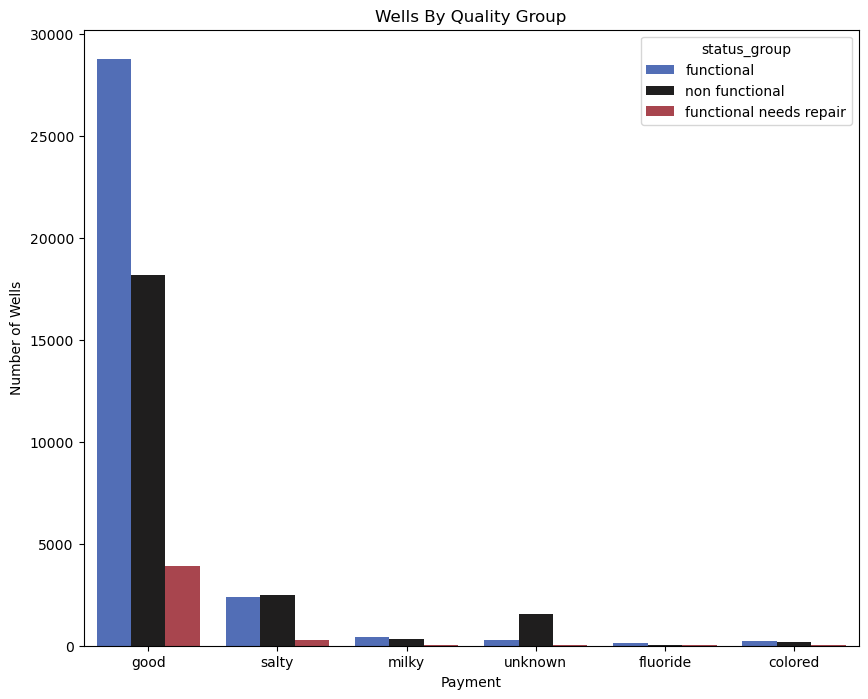

In [1435]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x='quality_group', hue="status_group", data=training_data, palette = 'icefire')
ax.set_xlabel('Payment')
ax.set_ylabel('Number of Wells')
ax.set_title('Wells By Quality Group');


## Objective 2: Wells by Payment Type

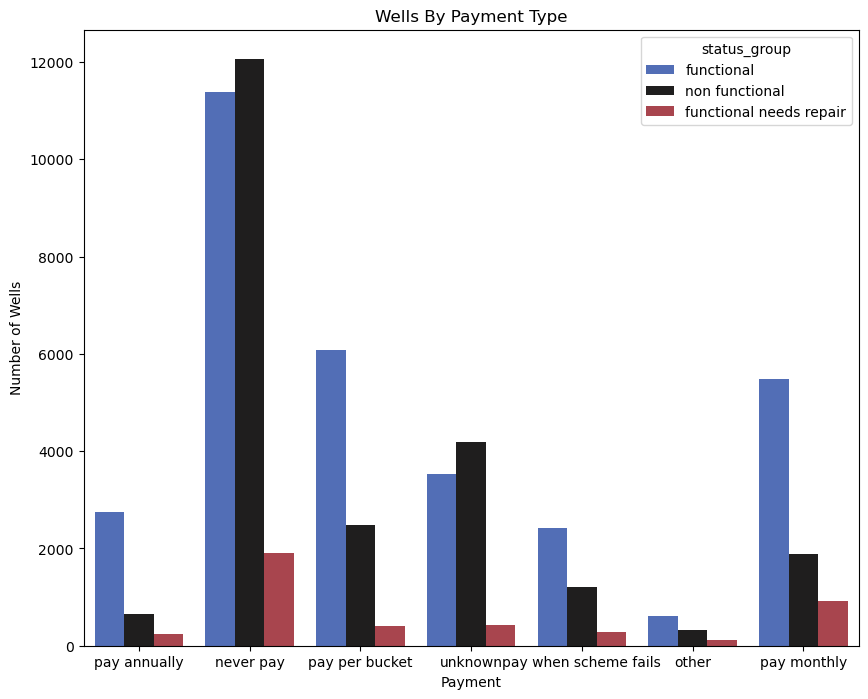

In [1436]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x='payment', hue="status_group", data=training_data, palette = 'icefire')
ax.set_xlabel('Payment')
ax.set_ylabel('Number of Wells')
ax.set_title('Wells By Payment Type');


## Wells by Waterpoint Type

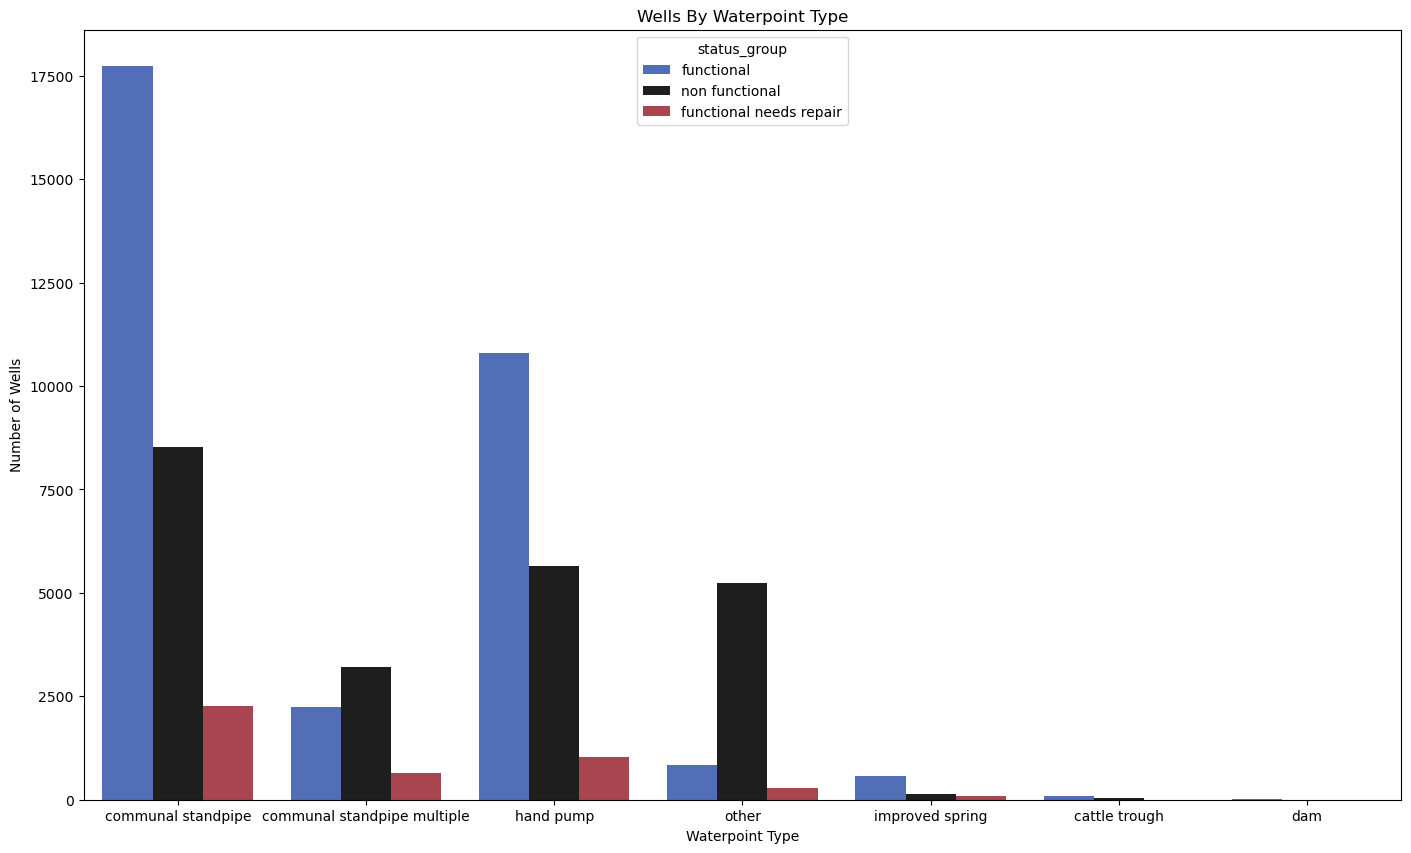

In [1532]:
plt.figure(figsize=(17,10))
ax = sns.countplot(x='waterpoint_type', hue="status_group", data=training_data, palette = 'icefire')
ax.set_xlabel('Waterpoint Type')
ax.set_ylabel('Number of Wells')
ax.set_title('Wells By Waterpoint Type');

## Wells by Quantity

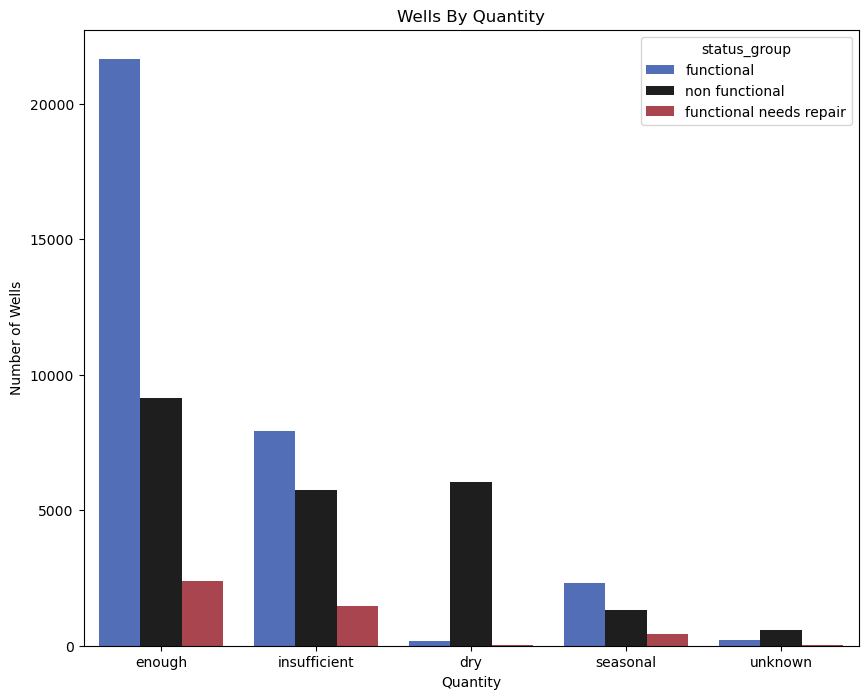

In [1437]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x='quantity', hue="status_group", data=training_data, palette = 'icefire')
ax.set_xlabel('Quantity')
ax.set_ylabel('Number of Wells')
ax.set_title('Wells By Quantity');

## Wells By Basin

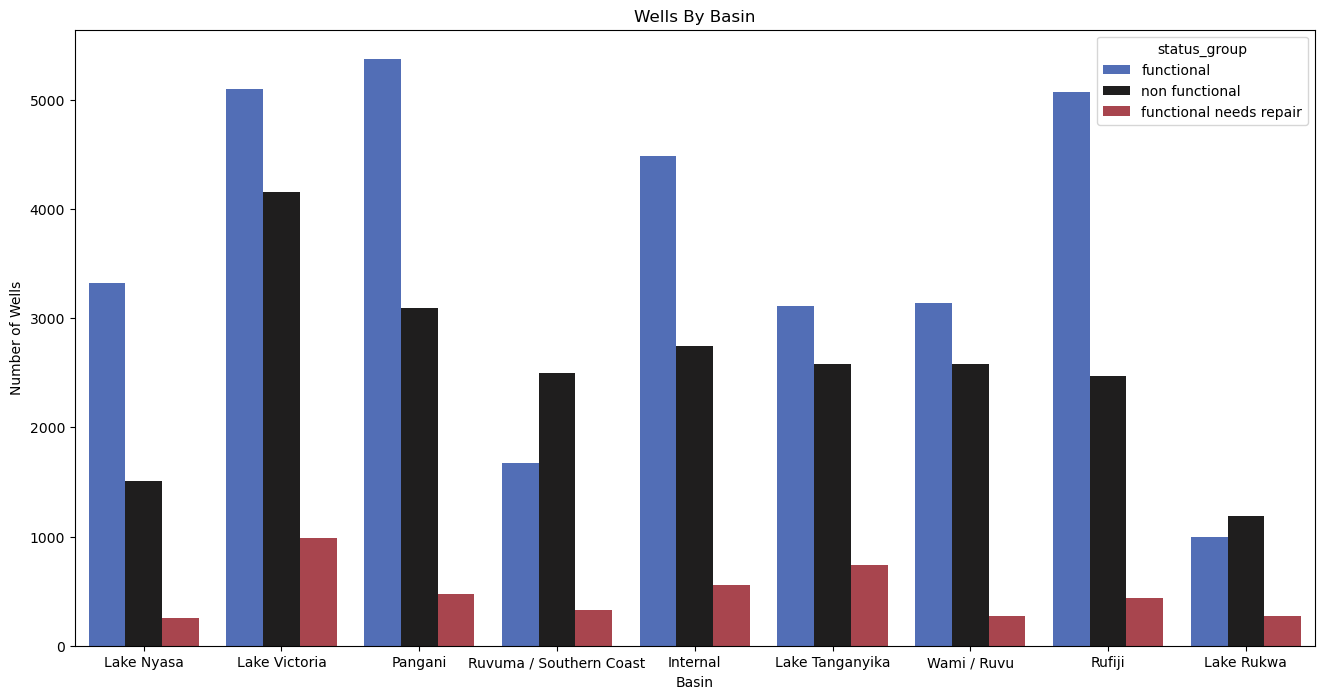

In [1539]:
plt.figure(figsize=(16,8))
ax = sns.countplot(x='basin', hue="status_group", data=training_data, palette = 'icefire')
ax.set_xlabel('Basin')
ax.set_ylabel('Number of Wells')
ax.set_title('Wells By Basin');

## Wells by Source

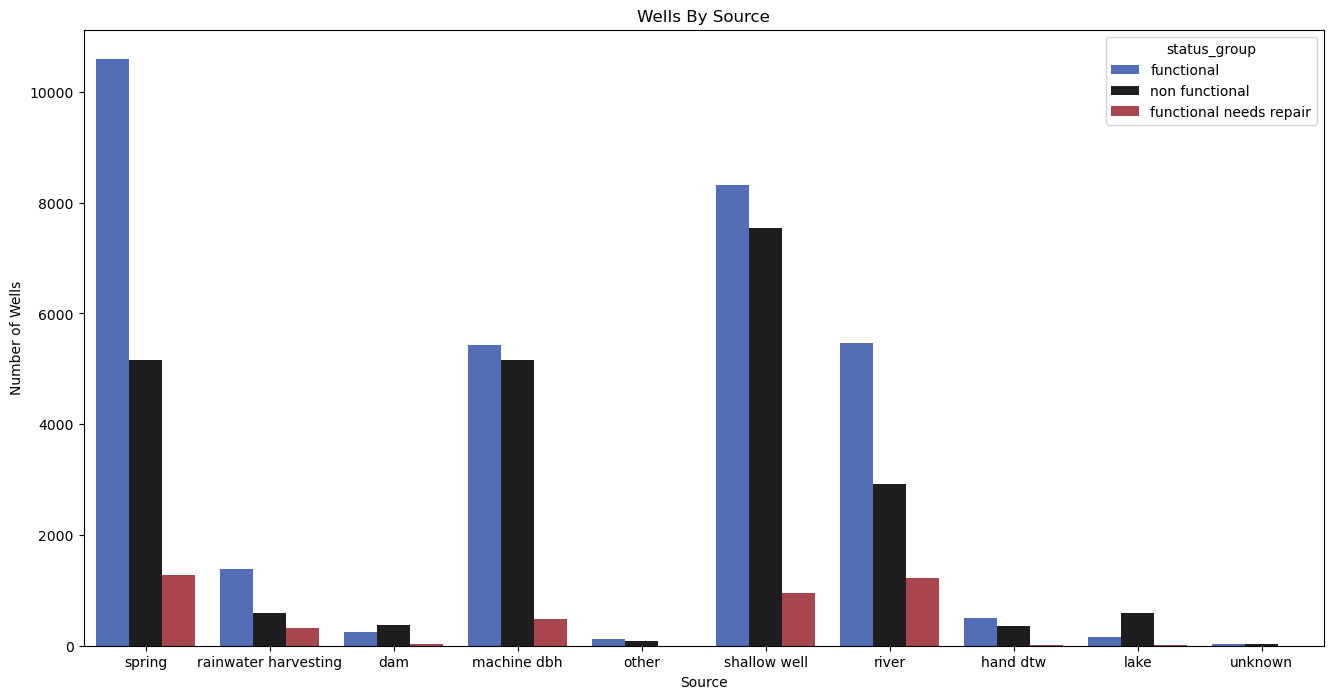

In [1534]:
plt.figure(figsize=(16,8))
ax = sns.countplot(x='source', hue="status_group", data=training_data, palette = 'icefire')
ax.set_xlabel('Source')
ax.set_ylabel('Number of Wells')
ax.set_title('Wells By Source');

## Wells By Management Group

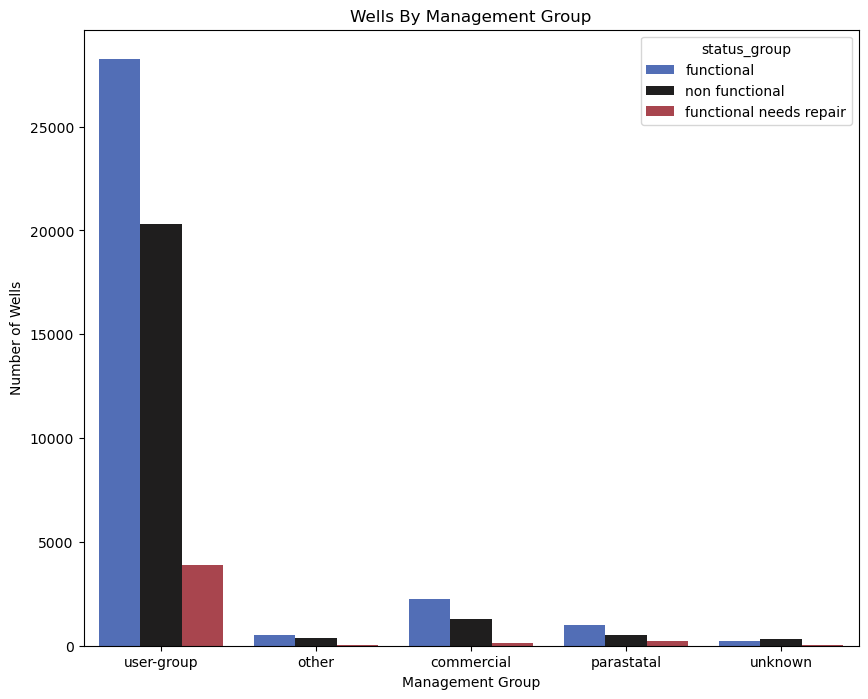

In [1535]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x='management_group', hue="status_group", data=training_data, palette = 'icefire')
ax.set_xlabel('Management Group')
ax.set_ylabel('Number of Wells')
ax.set_title('Wells By Management Group');

## Wells By Extraction Type Class

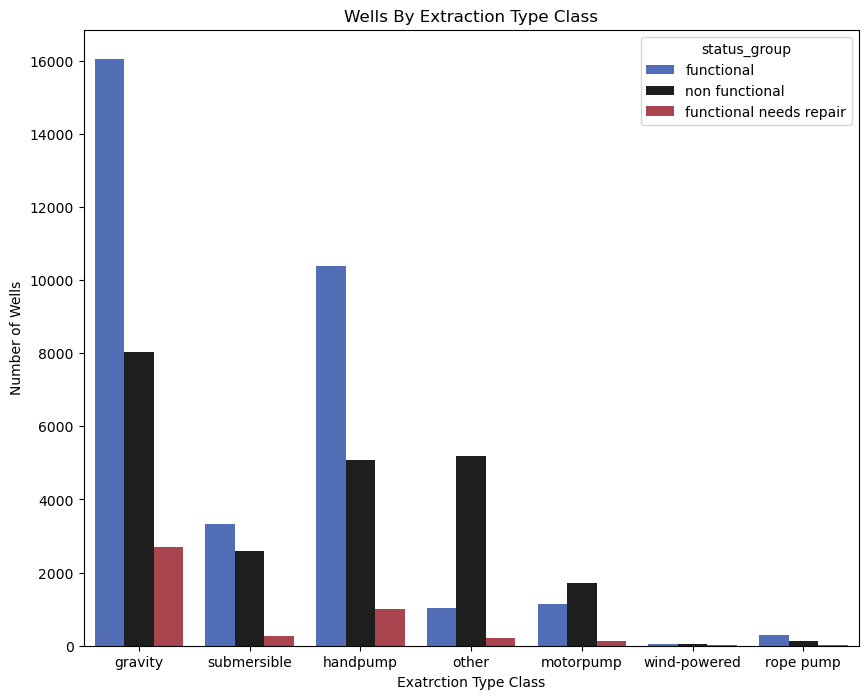

In [1536]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x='extraction_type_class', hue="status_group", data=training_data, palette = 'icefire')
ax.set_xlabel('Exatraction Type Class')
ax.set_ylabel('Number of Wells')
ax.set_title('Wells By Extraction Type Class');

## Wells By Permit

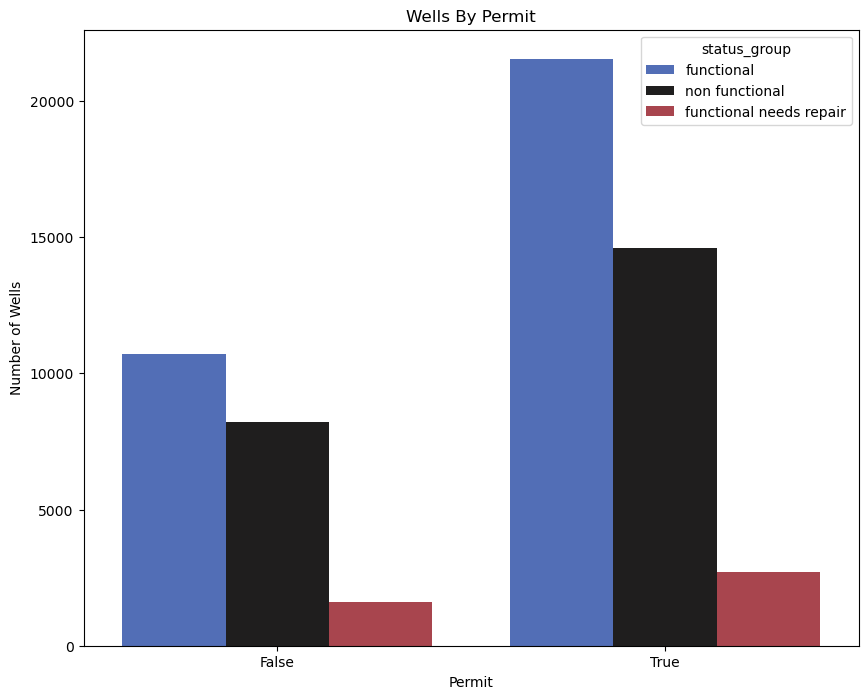

In [1542]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x='permit', hue="status_group", data=training_data, palette = 'icefire')
ax.set_xlabel('Permit')
ax.set_ylabel('Number of Wells')
ax.set_title('Wells By Permit');

## Wells By Public Meeting

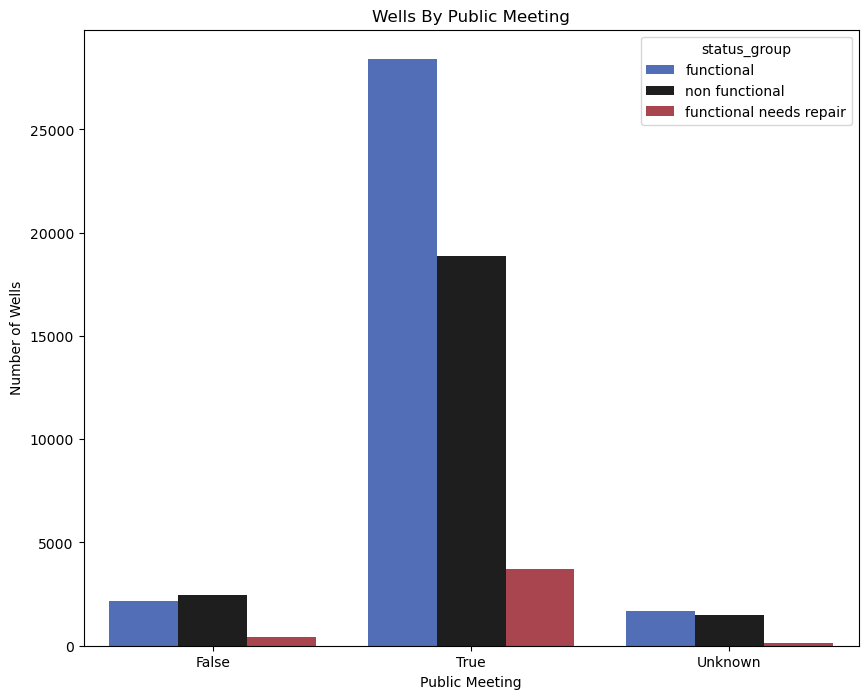

In [1544]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x='public_meeting', hue="status_group", data=training_data, palette = 'icefire')
ax.set_xlabel('Public Meeting')
ax.set_ylabel('Number of Wells')
ax.set_title('Wells By Public Meeting');

# Basic Model
Create an initial dataframe dropping all the uninformative features, as well as the categorical features with a large number of levels:

In [1438]:
initial_numeric_cols = ["id", "gps_height",
                        "population",
                        "construction_year"]

In [1439]:
initial_object_cols = ["basin",
                       "month_recorded",
                       "region",
                       "public_meeting",
                       "permit",
                       "extraction_type_class",
                       "management_group",
                       "payment",
                       "quality_group",
                       "quantity",
                       "source",
                       "waterpoint_type"]

In [1440]:
Xy_init = training_data[initial_numeric_cols + initial_object_cols + ["status_group"]].copy()

In [1441]:
Xy_init = Xy_init.set_index("id")

Check missing values

In [1442]:
Xy_init.isnull().sum()

gps_height               0
population               0
construction_year        0
basin                    0
month_recorded           0
region                   0
public_meeting           0
permit                   0
extraction_type_class    0
management_group         0
payment                  0
quality_group            0
quantity                 0
source                   0
waterpoint_type          0
status_group             0
dtype: int64

No missing values

In [1443]:
Xy_init.head()

,gps_height,population,construction_year,basin,month_recorded,region,public_meeting,permit,extraction_type_class,management_group,payment,quality_group,quantity,source,waterpoint_type,status_group
id,,,,,,,,,,,,,,,,
69572,1390,109,1999,Lake Nyasa,3,Iringa,True,False,gravity,user-group,pay annually,good,enough,spring,communal standpipe,functional
8776,1399,280,2010,Lake Victoria,3,Mara,Unknown,True,gravity,user-group,never pay,good,insufficient,rainwater harvesting,communal standpipe,functional
34310,686,250,2009,Pangani,2,Manyara,True,True,gravity,user-group,pay per bucket,good,enough,dam,communal standpipe multiple,functional
67743,263,58,1986,Ruvuma / Southern Coast,1,Mtwara,True,True,submersible,user-group,never pay,good,dry,machine dbh,communal standpipe multiple,non functional
19728,0,150,1996,Lake Victoria,7,Kagera,True,True,gravity,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,functional


## Feature Engineering

##### Outliers in numeric variables

In [1444]:
training_data[initial_numeric_cols].isnull().sum()

id                   0
gps_height           0
population           0
construction_year    0
dtype: int64

For `construction_year`, it was decided to impute the zero years with the mean. Also, it may be more suitable to derive a numeric feature construction_age expressing the time delta since construction instead of the original feature.

In [1445]:
Xy_init.construction_year.isnull().sum()

0

In [1446]:
current = datetime.now()

In [1447]:
Xy_init["construction_age"] = (current.year - Xy_init["construction_year"]).astype("int")

In [1448]:
Xy_init.construction_age.value_counts()

28    21520
14     2645
16     2613
15     2533
24     2091
17     1587
18     1471
21     1286
13     1256
20     1123
12     1084
22     1075
46     1037
29     1014
19     1011
25      979
26      966
34      954
39      945
44      811
40      779
42      744
30      738
52      708
50      676
27      644
32      640
31      608
23      540
36      521
41      488
49      437
38      434
48      414
54      411
33      324
35      316
37      302
43      238
47      202
45      192
51      184
11      176
53      145
64      102
57       88
61       85
56       77
55       59
60       40
62       30
63       21
59       19
58       17
Name: construction_age, dtype: int64

Drop `construction_year`

In [1449]:
Xy_init.drop('construction_year', axis=1, inplace=True)

In [1450]:
clean_numeric_cols = [
                        "gps_height",
                        "population",
                        "construction_age"]
clean_numeric_cols

['gps_height', 'population', 'construction_age']

In [1451]:
print(round(Xy_init[clean_numeric_cols].describe()),2)

       gps_height  population  construction_age
count     59400.0     59400.0           59400.0
mean        668.0       234.0              27.0
std         693.0       456.0              10.0
min         -90.0         1.0              11.0
25%           0.0       100.0              20.0
50%         369.0       150.0              28.0
75%        1319.0       215.0              28.0
max        2770.0     30500.0              64.0 2


In [1452]:
Xy_init.construction_age.isnull().sum()

0

I will draw boxplots to visualise outliers in the above variables. 

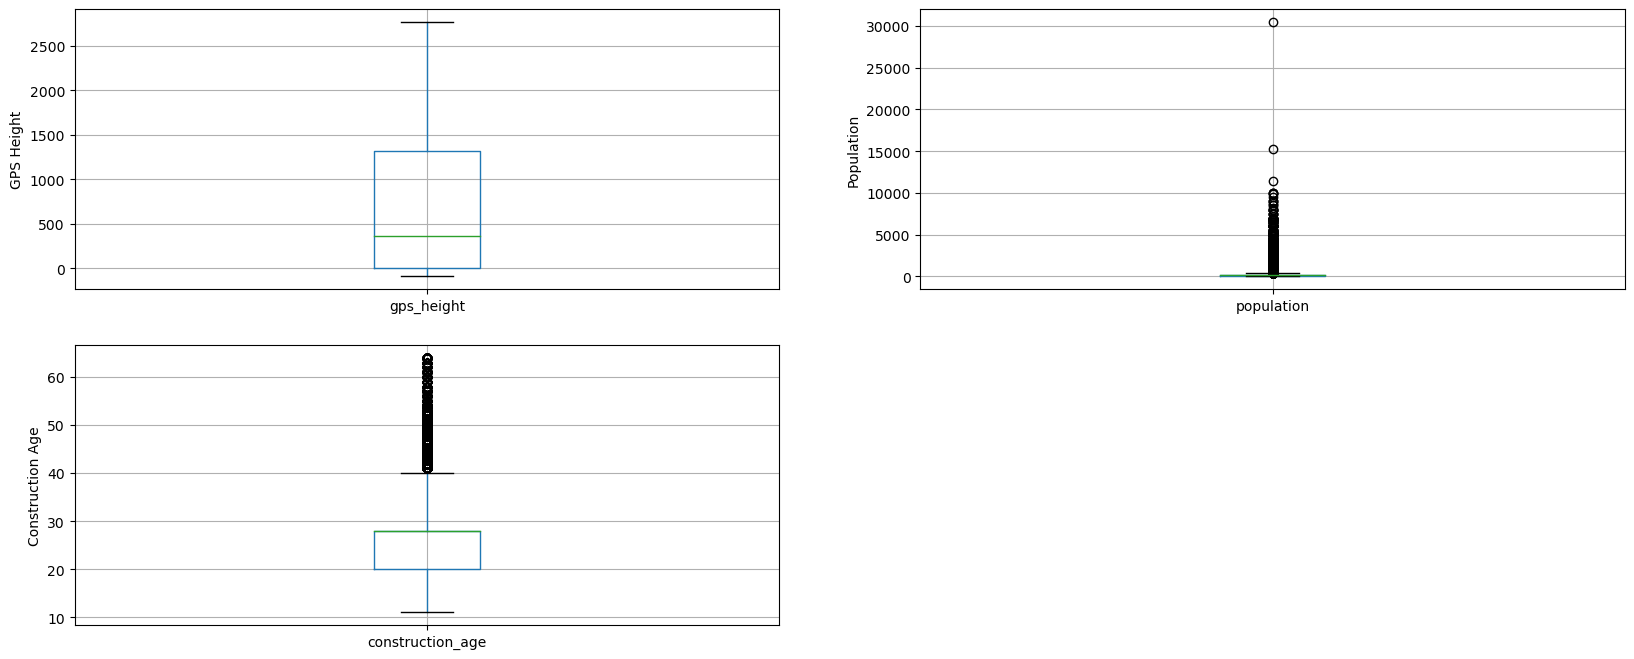

In [1453]:

plt.figure(figsize=(20,8))


plt.subplot(2, 2, 1)
fig = Xy_init.boxplot(column='gps_height')
fig.set_title('')
fig.set_ylabel('GPS Height')

plt.subplot(2, 2, 2)
fig = Xy_init.boxplot(column='population')
fig.set_title('')
fig.set_ylabel('Population')

plt.subplot(2, 2, 3)
fig = Xy_init.boxplot(column='construction_age')
fig.set_title('')
fig.set_ylabel('Construction Age');


##### Check the distribution of variables

Now, I will plot the histograms to check distributions to find out if they are normal or skewed. If the variable follows normal distribution, then I will do `Extreme Value Analysis` otherwise if they are skewed, I will find IQR (Interquantile range).

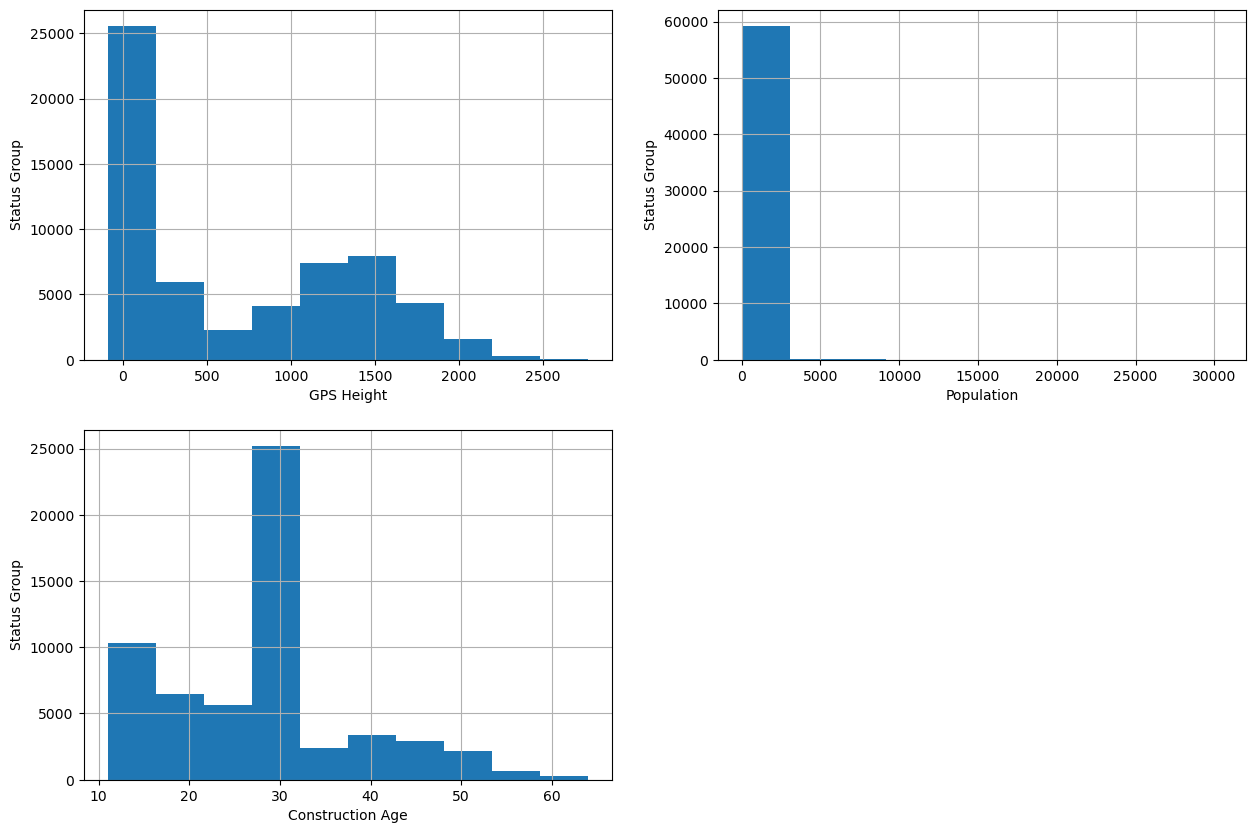

In [1454]:
# plot histogram to check distribution

plt.figure(figsize=(15,10))


plt.subplot(2, 2, 1)
fig = Xy_init["gps_height"].hist(bins=10)
fig.set_xlabel('GPS Height')
fig.set_ylabel('Status Group')

plt.subplot(2, 2, 2)
fig = Xy_init["population"].hist(bins=10)
fig.set_xlabel('Population')
fig.set_ylabel('Status Group')

plt.subplot(2, 2, 3)
fig = Xy_init["construction_age"].hist(bins=10)
fig.set_xlabel('Construction Age')
fig.set_ylabel('Status Group');


We can see that all the four variables are skewed. So, I will use interquantile range to find outliers.

##### GPS Height

In [1455]:
# find outliers for GPS Height variable

IQR = Xy_init["gps_height"].quantile(0.75) - Xy_init.gps_height.quantile(0.25)
Lower_fence = Xy_init["gps_height"].quantile(0.25) - (IQR * 3)
Upper_fence = Xy_init["gps_height"].quantile(0.75) + (IQR * 3)
print('GPS Height outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

GPS Height outliers are values < -3957.75 or > 5277.0


For `gps_height`, the minimum and maximum values are -90.0 and 2770.0. So, the outliers are values > 5277. There are no outliers

##### Population

In [1456]:
# find outliers for Population variable

IQR = Xy_init["population"].quantile(0.75) - Xy_init.population.quantile(0.25)
Lower_fence = Xy_init["population"].quantile(0.25) - (IQR * 3)
Upper_fence = Xy_init["population"].quantile(0.75) + (IQR * 3)
print('population outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

population outliers are values < -245.0 or > 560.0


For `population`, the minimum and maximum values are 1.0 and 30500.0. So, the outliers are values > 560. 

##### Construction Age

In [1457]:
# find outliers for Construction Age Variable

IQR = Xy_init["construction_age"].quantile(0.75) - Xy_init.construction_age.quantile(0.25)
Lower_fence = Xy_init["construction_age"].quantile(0.25) - (IQR * 3)
Upper_fence = Xy_init["construction_age"].quantile(0.75) + (IQR * 3)
print('Construction Age outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

Construction Age outliers are values < -4.0 or > 52.0


For `construction_age`, the minimum and maximum values are 11.0 and 64.0. So, the outliers are values > 52.0. 

In [1458]:
Xy_init['permit'] = Xy_init['permit'].astype(bool).astype(int) #converting from T/F to 0-1

In [1459]:
Xy_init['public_meeting'] = Xy_init['public_meeting'].astype(bool).astype(int) #converting from T/F to 0-1

Re-declaring numeric anc categorical columns. Moving `permit` and `public_meeting` to numeric now that they are 0-1

In [1460]:
initial_numeric_cols = ["id",
                        "gps_height",
                        "population",
                        "construction_year",
                        'permit',
                        'public_meeting']

In [1461]:
initial_object_cols = ['basin',
 'month_recorded',
 'region',
 'extraction_type_class',
 'management_group',
 'payment',
 'quality_group',
 'quantity',
 'source',
 'waterpoint_type']

In [1462]:
Xy_init[initial_object_cols] = Xy_init[initial_object_cols].astype("category")

In [1463]:
Xy_init.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   gps_height             59400 non-null  int64   
 1   population             59400 non-null  int64   
 2   basin                  59400 non-null  category
 3   month_recorded         59400 non-null  category
 4   region                 59400 non-null  category
 5   public_meeting         59400 non-null  int32   
 6   permit                 59400 non-null  int32   
 7   extraction_type_class  59400 non-null  category
 8   management_group       59400 non-null  category
 9   payment                59400 non-null  category
 10  quality_group          59400 non-null  category
 11  quantity               59400 non-null  category
 12  source                 59400 non-null  category
 13  waterpoint_type        59400 non-null  category
 14  status_group           59400 non-n

# Declare feature vector and target variable

In [1464]:
target_status_group = {'functional':0, 
                   'non functional': 2, 
                   'functional needs repair': 1} 
Xy_init['status_group'] = Xy_init['status_group'].replace(target_status_group)

To make our model, we changed the target variable to 0,1 and 2 values.

In [1465]:
training_data['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [1466]:
X = Xy_init.drop(['status_group'], axis=1)

y = Xy_init['status_group']

# **9. Split data into separate training and test set** 


In [1467]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [1468]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape

((47520, 15), (11880, 15))

# Feature Engineering

In [1469]:
# Check data types in x train

X_train.dtypes

gps_height                  int64
population                  int64
basin                    category
month_recorded           category
region                   category
public_meeting              int32
permit                      int32
extraction_type_class    category
management_group         category
payment                  category
quality_group            category
quantity                 category
source                   category
waterpoint_type          category
construction_age            int32
dtype: object

We already know that there are no missing values, but we can check to confirm

In [1470]:
X_train.isnull().sum()

gps_height               0
population               0
basin                    0
month_recorded           0
region                   0
public_meeting           0
permit                   0
extraction_type_class    0
management_group         0
payment                  0
quality_group            0
quantity                 0
source                   0
waterpoint_type          0
construction_age         0
dtype: int64

In [1471]:
X_test.isnull().sum()

gps_height               0
population               0
basin                    0
month_recorded           0
region                   0
public_meeting           0
permit                   0
extraction_type_class    0
management_group         0
payment                  0
quality_group            0
quantity                 0
source                   0
waterpoint_type          0
construction_age         0
dtype: int64

##### Engineering outliers in numerical variables

We have seen that the `population` and `construction_age`,  columns contain outliers

In [1472]:
upper_thresholds = {
    'population': 560.0,
    'construction_age': 52.0,
}

for df3 in [X_train, X_test]:
    for column, top in upper_thresholds.items():
        df3[column] = df3[column].clip(upper=top)

In [1473]:
print(round(X_train[clean_numeric_cols].describe()),2)

       gps_height  population  construction_age
count     47520.0     47520.0           47520.0
mean        669.0       184.0              27.0
std         693.0       153.0              10.0
min         -63.0         1.0              11.0
25%           0.0       100.0              20.0
50%         370.0       150.0              28.0
75%        1320.0       213.0              28.0
max        2770.0       560.0              52.0 2


In [1474]:
print(round(X_test[clean_numeric_cols].describe()),2)

       gps_height  population  construction_age
count     11880.0     11880.0           11880.0
mean        667.0       185.0              27.0
std         694.0       152.0              10.0
min         -90.0         1.0              11.0
25%           0.0       100.0              20.0
50%         365.0       150.0              28.0
75%        1316.0       220.0              28.0
max        2623.0       560.0              52.0 2


We can see that the outliers in `population` and `construction_age` have been removed

##### Encode categorical variables

In [1475]:
initial_object_cols

['basin',
 'month_recorded',
 'region',
 'extraction_type_class',
 'management_group',
 'payment',
 'quality_group',
 'quantity',
 'source',
 'waterpoint_type']

In [1476]:
X_train[initial_object_cols].head()

,basin,month_recorded,region,extraction_type_class,management_group,payment,quality_group,quantity,source,waterpoint_type
id,,,,,,,,,,
454,Internal,2,Manyara,gravity,user-group,pay per bucket,good,insufficient,spring,communal standpipe
510,Internal,3,Dodoma,handpump,user-group,never pay,good,enough,shallow well,hand pump
14146,Lake Rukwa,7,Mbeya,other,user-group,never pay,good,enough,shallow well,other
47410,Rufiji,4,Mbeya,gravity,user-group,pay monthly,good,insufficient,river,communal standpipe
1288,Wami / Ruvu,4,Morogoro,other,user-group,pay when scheme fails,salty,enough,shallow well,other


In [1477]:
X_train.head()

,gps_height,population,basin,month_recorded,region,public_meeting,permit,extraction_type_class,management_group,payment,quality_group,quantity,source,waterpoint_type,construction_age
id,,,,,,,,,,,,,,,
454,2092,160.0,Internal,2,Manyara,1,1,gravity,user-group,pay per bucket,good,insufficient,spring,communal standpipe,26.0
510,0,150.0,Internal,3,Dodoma,1,1,handpump,user-group,never pay,good,enough,shallow well,hand pump,28.0
14146,0,150.0,Lake Rukwa,7,Mbeya,1,0,other,user-group,never pay,good,enough,shallow well,other,28.0
47410,0,150.0,Rufiji,4,Mbeya,1,1,gravity,user-group,pay monthly,good,insufficient,river,communal standpipe,28.0
1288,1023,120.0,Wami / Ruvu,4,Morogoro,1,1,other,user-group,pay when scheme fails,salty,enough,shallow well,other,27.0


In [1478]:
# using ohe Recommended 

import category_encoders as ce

ohe = ce.one_hot.OneHotEncoder(cols=['basin','month_recorded','region', 'extraction_type_class', 'management_group', 'payment', 'quality_group',
                             'quantity', 'source', 'waterpoint_type'], handle_missing="value", handle_unknown="ignore")

ohe.fit(X_train)

X_train = ohe.transform(X_train)
X_test = ohe.transform(X_test)

##### Encode Status_group variable- Target

In [1479]:
# import category_encoders as ce

# binary_encoder = ce.BinaryEncoder(cols=['RainToday'])

# X_train = binary_encoder.fit_transform(X_train)

# X_test = binary_encoder.transform(X_test)

In [1480]:
X_train.head()

,gps_height,population,basin_1,basin_2,basin_3,basin_4,basin_5,basin_6,basin_7,basin_8,...,source_9,source_10,waterpoint_type_1,waterpoint_type_2,waterpoint_type_3,waterpoint_type_4,waterpoint_type_5,waterpoint_type_6,waterpoint_type_7,construction_age
id,,,,,,,,,,,,,,,,,,,,,
454,2092,160.0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,26.0
510,0,150.0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,28.0
14146,0,150.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,28.0
47410,0,150.0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,28.0
1288,1023,120.0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,27.0


In [1481]:
X_test.head()

,gps_height,population,basin_1,basin_2,basin_3,basin_4,basin_5,basin_6,basin_7,basin_8,...,source_9,source_10,waterpoint_type_1,waterpoint_type_2,waterpoint_type_3,waterpoint_type_4,waterpoint_type_5,waterpoint_type_6,waterpoint_type_7,construction_age
id,,,,,,,,,,,,,,,,,,,,,
37098,0,150.0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,28.0
14530,0,150.0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,28.0
62607,1675,148.0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,16.0
46053,0,150.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,28.0
47083,1109,235.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,13.0


We now have training and testing set ready for model building. Before that, we should map all the feature variables onto the same scale. It is called `feature scaling`. I will do it as follows.

In [1482]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

MinMaxScaler()

In [1483]:
X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
    )

In [1484]:
X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
    )

In [1485]:
X_train.head()

,gps_height,population,basin_1,basin_2,basin_3,basin_4,basin_5,basin_6,basin_7,basin_8,...,source_9,source_10,waterpoint_type_1,waterpoint_type_2,waterpoint_type_3,waterpoint_type_4,waterpoint_type_5,waterpoint_type_6,waterpoint_type_7,construction_age
0,0.760678,0.284436,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.365854
1,0.022238,0.266547,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.414634
2,0.022238,0.266547,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.414634
3,0.022238,0.266547,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.414634
4,0.383339,0.212880,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.390244


In [1486]:
X_train.isnull().sum()

gps_height           0
population           0
basin_1              0
basin_2              0
basin_3              0
                    ..
waterpoint_type_4    0
waterpoint_type_5    0
waterpoint_type_6    0
waterpoint_type_7    0
construction_age     0
Length: 94, dtype: int64

In [1487]:
X_test.isnull().sum()

gps_height           0
population           0
basin_1              0
basin_2              0
basin_3              0
                    ..
waterpoint_type_4    0
waterpoint_type_5    0
waterpoint_type_6    0
waterpoint_type_7    0
construction_age     0
Length: 94, dtype: int64

We now have `X_train` dataset ready to be fed into the Logistic Regression classifier. I will do it as follows.

# Model Training

## Model 1- Logistic Regression

In [1488]:
# instantiate the model
logreg = LogisticRegression(solver='sag', max_iter=400, multi_class='auto', random_state=42)


# fit the model
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=400, random_state=42, solver='sag')

In [1489]:
y_pred_test = logreg.predict(X_test)

y_pred_test

array([2, 0, 0, ..., 2, 0, 0], dtype=int64)

In [1490]:
# Check accuracy score

from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score: 0.7297


Here, **y_test** are the true class labels and **y_pred_test** are the predicted class labels in the test-set.

### Compare the train-set and test-set accuracy


Now, I will compare the train-set and test-set accuracy to check for overfitting.

In [1491]:
y_pred_train = logreg.predict(X_train)

y_pred_train

array([0, 0, 2, ..., 2, 0, 2], dtype=int64)

In [1492]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.7322


Check for overfitting or underfitting

In [1493]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(logreg.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(logreg.score(X_test, y_test)))

Training set score: 0.7322
Test set score: 0.7297


The training-set accuracy score is 0.7315 while the test-set accuracy is 0.7300. These two values are quite comparable. So, there is no question of overfitting. 


In Logistic Regression, we use default value of C = 1. It provides good performance with approximately 73% accuracy on both the training and the test set. But the model performance on both the training and test set are very comparable. It is likely the case of underfitting. 

I will increase C and fit a more flexible model.

In [1494]:
# fit the Logsitic Regression model with C=100

# instantiate the model
logreg100 = LogisticRegression(C=100, solver='sag', random_state=42)


# fit the model
logreg100.fit(X_train, y_train)

c:\Users\rosew\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=100, random_state=42, solver='sag')

In [1495]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(logreg100.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(logreg100.score(X_test, y_test)))

Training set score: 0.7304
Test set score: 0.7294


We can see that, C=100 results in slightly test set accuracy and also a slightly reduced training set accuracy. So, we can conclude that a more complex model does not perform better.

Now, I will investigate, what happens if we use more regularized model than the default value of C=1, by setting C=0.01.

In [1496]:
# fit the Logsitic Regression model with C=001

# instantiate the model
logreg001 = LogisticRegression(C=0.01, solver='sag', random_state=42)


# fit the model
logreg001.fit(X_train, y_train)

LogisticRegression(C=0.01, random_state=42, solver='sag')

In [1497]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(logreg001.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(logreg001.score(X_test, y_test)))

Training set score: 0.7303
Test set score: 0.7307


The training and test set accuracy scores are also lower than the original, so we will continue from the one that used default c= 1

This will be our baseline model. Now let's try to change up some things and see what that does to our model

Confusion matrix

 [[5844   20  593]
 [ 654   46  151]
 [1764   29 2779]]


Text(0.5, 1.0, 'Confusion Matrix')

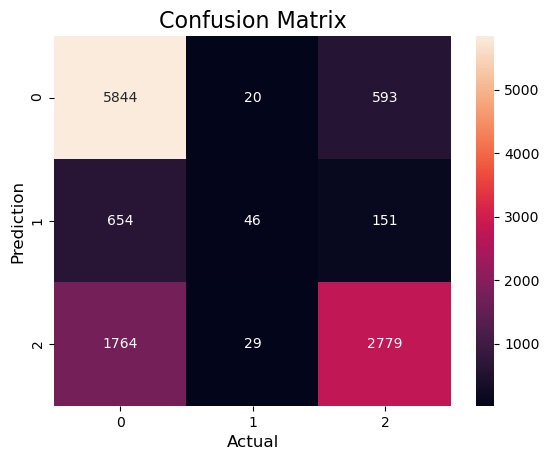

In [1498]:

from sklearn.metrics import confusion_matrix


cm_logreg1 = confusion_matrix(y_test, y_pred_test)
print('Confusion matrix\n\n', cm_logreg1)

sns.heatmap(cm_logreg1, annot=True,fmt='d')
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
# plt.show();



Remember that:<br>
0: Functional:<br>
1: functional needs repair<br>
2: non-functional

In [1499]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.71      0.91      0.79      6457
           1       0.48      0.05      0.10       851
           2       0.79      0.61      0.69      4572

    accuracy                           0.73     11880
   macro avg       0.66      0.52      0.53     11880
weighted avg       0.72      0.73      0.70     11880



The weighted average precision and recall are preferred as evaluation metrics.  
It is appropriate to use weighted averaging. This approach takes into account the balance of classes. You weigh each class based on its representation in the dataset. Then, you compute precision and recall as a weighted average of the precision and recall in individual classes.

Simply put, it would work like macro-averaging, but instead of dividing precision and recall by the number of classes, you give each class a fair representation based on the proportion it takes in the dataset. 

This approach is useful if you have an imbalanced dataset, like we have here but want to assign larger importance to classes with more examples. 

## Model 2- Logistic Regression Iteration Two

Our target variable is hughly imbalanced. We will create a copy and use SMOTE to balance it then create a second iteration

In [1500]:
Xy_init.status_group.value_counts()

0    32259
2    22824
1     4317
Name: status_group, dtype: int64

In [1501]:
Xy_init_smote = Xy_init.copy() # assign to protect original one 

X_smote = Xy_init_smote.drop(['status_group'], axis=1) # assign X variables

y_smote = Xy_init_smote['status_group'] # Assign y variable

from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_smote, y_smote, test_size = 0.2, random_state = 42) # Train test split

# Remove outliers for numerical data

upper_thresholds = {
    'population': 560.0,
    'construction_age': 52.0,
}                                 

for df3 in [X_train2, X_test2]:
    for column, top in upper_thresholds.items():
        df3[column] = df3[column].clip(upper=top)

# Obe Hot encode categorical data

import category_encoders as ce

ohe = ce.one_hot.OneHotEncoder(cols=['basin','month_recorded','region', 'extraction_type_class', 'management_group', 'payment', 'quality_group',
                             'quantity', 'source', 'waterpoint_type'], handle_missing="value", handle_unknown="ignore")

ohe.fit(X_train2)

X_train2 = ohe.transform(X_train2)
X_test2 = ohe.transform(X_test2)

# Scale the data

from sklearn.preprocessing import MinMaxScaler

scaler2 = MinMaxScaler()

scaler2.fit(X_train2)


X_train2 = pd.DataFrame(
    scaler.transform(X_train2),
    columns=X_train2.columns
    )


X_test2 = pd.DataFrame(
    scaler.transform(X_test2),
    columns=X_test2.columns
    )

# SMOTE
from imblearn.over_sampling import SMOTE 


smt = SMOTE(sampling_strategy = 'auto', n_jobs = -1)

X_smote_sampled, y_smote_sampled = smt.fit_resample(X_train2, y_train2)

print(y_smote.value_counts())

y_smote_sampled = pd.Series(y_smote_sampled) # converting from array to np.series to see value_counts

print(y_smote_sampled.value_counts())




# # Instantiate and Fit Logistic Regression Model
# # instantiate the model
logreg2 = LogisticRegression(solver='sag', multi_class='auto', random_state=42)


# # fit the model
logreg2.fit(X_smote_sampled, y_smote_sampled)

0    32259
2    22824
1     4317
Name: status_group, dtype: int64
2    25802
1    25802
0    25802
Name: status_group, dtype: int64


c:\Users\rosew\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(random_state=42, solver='sag')

In [1502]:
y_pred_test2 = logreg2.predict(X_test2)

y_pred_test2

array([2, 0, 0, ..., 2, 1, 0], dtype=int64)

In [1503]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test2, y_pred_test2)))

Model accuracy score: 0.6227


### Compare the train-set and test-set accuracy


Now, I will compare the train-set and test-set accuracy to check for overfitting.

In [1504]:
y_pred_train2 = logreg2.predict(X_train2)

y_pred_train2

array([0, 0, 2, ..., 2, 1, 2], dtype=int64)

In [1505]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train2, y_pred_train2)))

Training-set accuracy score: 0.6277


Check for overfitting or underfitting

In [1506]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(logreg2.score(X_train2, y_train2)))

print('Test set score: {:.4f}'.format(logreg2.score(X_test2, y_test2)))

Training set score: 0.6277
Test set score: 0.6227


The training and test accuracy score are much lower than the first model, meaning that it is less accurate. Using SMOTE does not improve our model

Confusion matrix

 [[4059 1733  665]
 [ 210  542   99]
 [ 958  817 2797]]


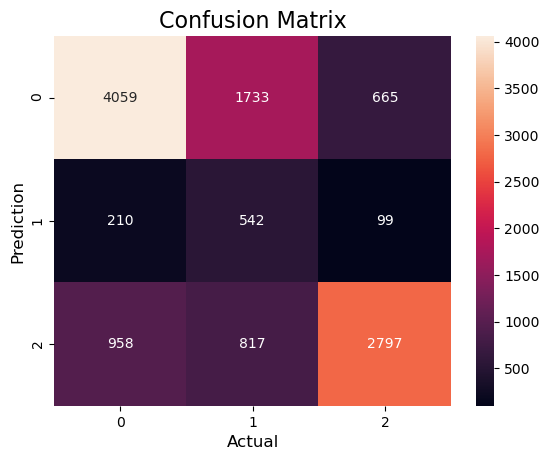

In [1549]:
from sklearn.metrics import confusion_matrix


cm_logreg3 = confusion_matrix(y_test2, y_pred_test2)
print('Confusion matrix\n\n', cm_logreg3)

sns.heatmap(cm_logreg3, annot=True,fmt='d')
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show();

In [1550]:
from sklearn.metrics import classification_report

print(classification_report(y_test2, y_pred_test2))

              precision    recall  f1-score   support

           0       0.78      0.63      0.69      6457
           1       0.18      0.64      0.27       851
           2       0.79      0.61      0.69      4572

    accuracy                           0.62     11880
   macro avg       0.58      0.63      0.55     11880
weighted avg       0.74      0.62      0.66     11880



Let's now try using the standard scaler instead on the MinMax Scaler on the original data to see if this creates a better model

## Model 3: Linear Regression Iteration 3

In [1507]:
Xy_init_std_scaler = Xy_init.copy() # assign to protect original one 

X_std_scaler = Xy_init_std_scaler.drop(['status_group'], axis=1) # assign X variables

y_std_scaler = Xy_init_std_scaler['status_group'] # Assign y variable

from sklearn.model_selection import train_test_split

X_train3, X_test3, y_train3, y_test3 = train_test_split(X_std_scaler, y_std_scaler, test_size = 0.2, random_state = 42) # Train test split

# Remove outliers for numerical data

upper_thresholds = {
    'population': 560.0,
    'construction_age': 52.0,
}                                 

for df3 in [X_train3, X_test3]:
    for column, top in upper_thresholds.items():
        df3[column] = df3[column].clip(upper=top)

# Obe Hot encode categorical data

import category_encoders as ce

ohe = ce.one_hot.OneHotEncoder(cols=['basin','month_recorded','region', 'extraction_type_class', 'management_group', 'payment', 'quality_group',
                             'quantity', 'source', 'waterpoint_type'], handle_missing="value", handle_unknown="ignore")

ohe.fit(X_train3)

X_train3 = ohe.transform(X_train3)
X_test3 = ohe.transform(X_test3)

# Scale the data

from sklearn.preprocessing import StandardScaler

scaler3 = StandardScaler()

scaler3.fit(X_train3)


X_train3 = pd.DataFrame(
    scaler3.transform(X_train3),
    columns=X_train3.columns
    )


X_test3 = pd.DataFrame(
    scaler3.transform(X_test3),
    columns=X_test3.columns
    )


# # Instantiate and Fit Logistic Regression Model
# # instantiate the model
logreg3 = LogisticRegression(solver='sag', multi_class='auto', random_state=42)


# # fit the model
logreg3.fit(X_train3, y_train3)

LogisticRegression(random_state=42, solver='sag')

In [1508]:
y_pred_test3 = logreg3.predict(X_test3)

y_pred_test3

array([2, 0, 0, ..., 2, 0, 0], dtype=int64)

In [1509]:
from sklearn.metrics import accuracy_score

print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test3, y_pred_test3)))

Model accuracy score: 0.7295


In [1510]:
### Compare the train-set and test-set accuracy


# Now, I will compare the train-set and test-set accuracy to check for overfitting.
y_pred_train3 = logreg3.predict(X_train3)

y_pred_train3

print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train3, y_pred_train3)))
# Check for overfitting or underfitting
# print the scores on training and test set

print('Training set score: {:.4f}'.format(logreg3.score(X_train3, y_train3)))

print('Test set score: {:.4f}'.format(logreg3.score(X_test3, y_test3)))


Training-set accuracy score: 0.7323
Training set score: 0.7323
Test set score: 0.7295


The training and test accuracy score are similar to the first model at 0.73 and 0.729

Confusion matrix

 [[5842   23  592]
 [ 654   46  151]
 [1764   29 2779]]


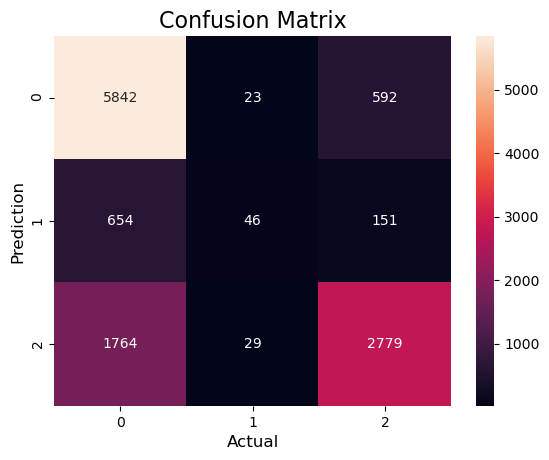

In [1551]:
from sklearn.metrics import confusion_matrix


cm_logreg4 = confusion_matrix(y_test3, y_pred_test3)
print('Confusion matrix\n\n', cm_logreg4)

sns.heatmap(cm_logreg4, annot=True,fmt='d')
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show();

In [1552]:
from sklearn.metrics import classification_report

print(classification_report(y_test3, y_pred_test3))

              precision    recall  f1-score   support

           0       0.71      0.90      0.79      6457
           1       0.47      0.05      0.10       851
           2       0.79      0.61      0.69      4572

    accuracy                           0.73     11880
   macro avg       0.66      0.52      0.53     11880
weighted avg       0.72      0.73      0.70     11880



## Feature Elimination

Working with the first model `logreg`, we will use feature selection to choose the best 10 features for use

In [1540]:
# # import pandas as pd
# # # # Load the dataset
# # # X = ... # features
# # # y = ... # target
# from sklearn.feature_selection import SelectKBest, chi2
# # Use SelectKBest to select the top 10 features
# selector = SelectKBest(chi2, k=10)
# X_new = selector.fit_transform(X_train, y_train)

# names = selector.get_feature_names_out()
# df = pd.DataFrame(X_new, columns = [names])

# # Print the selected features
# print(selector.get_support())
# names

# # # from sklearn.feature_selection import SelectKBest, f_regression

# # # X_opt=SelectKBest(f_regression,k=2000)
# # # X_new=X_opt.fit_transform(df_train_X_mm, train_y)

# # # names = X_opt.get_feature_names_out()

# # # df = pd.Dataframe(X_new, columns = [names])



[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False  True False False False False
 False False False False False False False False False False  True False
  True False False False False False False False False False False  True
  True False False False False False False  True False False False False
  True False  True False False False False False False False False False
 False False False False  True False False False False False]


array(['region_7', 'region_9', 'extraction_type_class_1',
       'extraction_type_class_3', 'payment_2', 'payment_3',
       'quality_group_3', 'quantity_2', 'quantity_4', 'waterpoint_type_3'],
      dtype=object)

In [1512]:
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression

# # # Load the dataset
# # X = ... # features
# # y = ... # target

# # # Create a logistic regression model
# # model = LogisticRegression()

# # Use RFE to select the top 10 features
# rfe = RFE(logreg, n_features_to_select=10)
# rfe.fit(X_train, y_train)

# # Print the selected features
# print(rfe.support_)

# Decision Tree 

## Model 4: Decision Tree- Model Iteration 1

In [1513]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [1514]:
dt= DecisionTreeClassifier(criterion='gini', splitter='best', random_state=42)


In [1515]:

dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [1516]:
print('Accuracy score of train data :{}'.format(dt.score(X_train,y_train)))
print('Accuracy score of test data:{}'.format(dt.score(X_test,y_test)))

Accuracy score of train data :0.937962962962963
Accuracy score of test data:0.7570707070707071


This high variance in accuracy scores indicates that we are overfitting. Let's change the depth and use entropy and see the difference it brings

## Model 5: Decision Tree- Model Iteration Two: Hyperparameter Tuning for the Decision Tree

In [1546]:
dt2= DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth= 14, random_state=42)
dt2.fit(X_train, y_train)
print('Accuracy score of train data :{}'.format(dt2.score(X_train,y_train)))
print('Accuracy score of test data:{}'.format(dt2.score(X_test,y_test)))

Accuracy score of train data :0.7965698653198653
Accuracy score of test data:0.7576599326599327


In [1547]:
y_pred_test4 = dt.predict(X_test)

y_pred_test4

array([2, 0, 0, ..., 2, 0, 0], dtype=int64)

This has improved both accuracy scores and we are not overfitting either. This could be perfect for the final model

Let's create a confusion matrix for this and calculate other classification metrics

Confusion matrix

 [[5789   94  574]
 [ 533  177  141]
 [1458   79 3035]]


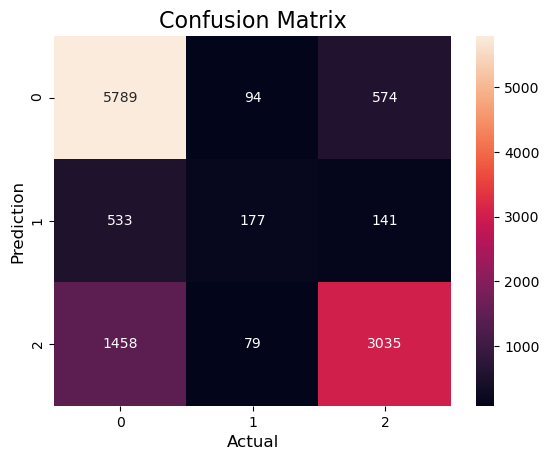

In [1519]:

from sklearn.metrics import confusion_matrix


cm_logreg2 = confusion_matrix(y_test, y_pred_test4)
print('Confusion matrix\n\n', cm_logreg2)

sns.heatmap(cm_logreg2, annot=True,fmt='d')
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show();



Remember that:<br>
0: Functional:<br>
1: functional needs repair<br>
2: non-functional

In [1520]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test4))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81      6457
           1       0.51      0.21      0.29       851
           2       0.81      0.66      0.73      4572

    accuracy                           0.76     11880
   macro avg       0.69      0.59      0.61     11880
weighted avg       0.75      0.76      0.74     11880



## Exploring the Target Column

In [1521]:
# training_data['status_group'].value_counts()

We have highly imbalanced target values.

In [1522]:
# There are no missing values in the target data
# training_data['status_group'].isnull().sum()

In [1523]:
# # Let's look at the distribution of the target
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns
# sns.set_style("whitegrid")

# target_histplot = sns.countplot(x= training_data['status_group'], palette="icefire")


# target_histplot.set_title("Distribution of Status Groups")
# target_histplot.set_ylabel('Number in Group')
# target_histplot.set_xlabel('Status Groups')
# target_histplot;

##### Converting Target to Ternary Values

In [1524]:
# target_status_group = {'functional':0, 
#                    'non functional': 2, 
#                    'functional needs repair': 1} 
# training_data['status_group'] = training_data['status_group'].replace(target_status_group)

To make our model, we changed the target variable to 0,1 and 2 values.

In [1525]:
# training_data['status_group'].value_counts()

In [1526]:
# training_data.to_csv('clean_data.csv')